# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import warnings
import glob
import imageio
import os
import logging
import re
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Preprocessed the data

In [4]:
file_path_train = r'/home/shoaib/Programming/Project/data'

In [5]:
# function to find the folders of training or test


def find_folders(path,search,csv=False):
    list_of_folders = []
    
    if csv==False:
        for i in os.listdir(path):
            training_folder_ptr = re.search(search,i)                     # search for pattern
            if training_folder_ptr != None:                               # if pattern matches
                if i.endswith('.csv') != True:                            # grabs only the non csv string
                    list_of_folders.append(os.path.join(path,i))          # join and create the path
    else:
        for i in os.listdir(path):
            training_folder_ptr = re.search(search,i)
            if training_folder_ptr != None:
                if i.endswith('.csv') == True:
                    list_of_folders.append(os.path.join(path,i))
    return list_of_folders

In [6]:
training_image_file_path_list = find_folders(file_path_train,r'training')
training_csv_file_path_list = find_folders(file_path_train,r'training',csv=True)

In [7]:
training_image_file_path_list

['/home/shoaib/Programming/Project/data/training-e',
 '/home/shoaib/Programming/Project/data/training-b',
 '/home/shoaib/Programming/Project/data/training-a',
 '/home/shoaib/Programming/Project/data/training-d',
 '/home/shoaib/Programming/Project/data/training-c']

In [8]:
training_csv_file_path_list

['/home/shoaib/Programming/Project/data/training-b.csv',
 '/home/shoaib/Programming/Project/data/training-e.csv',
 '/home/shoaib/Programming/Project/data/training-a.csv',
 '/home/shoaib/Programming/Project/data/training-d.csv',
 '/home/shoaib/Programming/Project/data/training-c.csv']

In [9]:
# create a function to convert the image into np array

def grab_all_img(list_of_folders):
    
    all_img_path = []
    all_img_name = []
    for i in range(len(list_of_folders)):
        img_list = glob.glob(list_of_folders[i]+'/*.png')
        all_img_path.extend(img_list)
    
    for i in range(len(all_img_path)):
        all_img_name.append(all_img_path[i].split(sep=os.sep)[-1])   # splitting abc/12av.png into abc,12av.png and -1 return last index value
    
    return all_img_path,all_img_name

In [10]:
traininig_image_path,training_img_name = grab_all_img(training_image_file_path_list)

In [11]:
len(traininig_image_path)

72045

In [12]:
# create a class which will have np data and label

class image_data():
    
    def __init__(self,image,label=None):
        self.image = image
        self.label = label
    
    def get_image(self):
        return self.image
    def get_label(self):
        return self.label

In [13]:
# function to get the labels

def get_img_label(file_path_list,image_name_list):
    df_list = []
    for i in range(len(file_path_list)):
        df = pd.read_csv(file_path_list[i])
        df_list.append(df)
    
    # concat the dataframe
    all_df = pd.concat(df_list,ignore_index=True)
    all_df = all_df.set_index('filename') # changing the index to the filename
    
    y_label = []
    
    # get the labels
    
    for i in range(len(image_name_list)):
        label = all_df.loc[image_name_list[i]]['digit']
        y_label.append(label)
    return y_label

In [14]:
train_image_label = get_img_label(file_path_list=training_csv_file_path_list,image_name_list=training_img_name)

In [15]:
def img_to_obj(image_path_list,image_label_list=None):
    
    img_obj_list = []
    # read the image for training dataset
    if image_label_list != None:
        for i in range(len(image_path_list)):
            img = cv.imread(image_path_list[i],cv.IMREAD_GRAYSCALE)  # read the image in grayscale
            label = image_label_list[i]

            # creating a new obj
            obj = image_data(image=img,label=label)
            img_obj_list.append(obj)

            print('Training Image processed {}/{}'.format(i+1,len(image_path_list)),end='\r')
        return img_obj_list
    else:
        for i in range(len(image_path_list)):
            img = cv.imread(image_path_list[i],cv.IMREAD_GRAYSCALE)  # read the image in grayscale
            # creating a new obj
            obj = image_data(image=img)
            img_obj_list.append(obj)
            
            print('Test Image processed {}/{}'.format(i+1,len(image_path_list)),end='\r')
        return img_obj_list

In [16]:
training_img_as_obj_list = img_to_obj(traininig_image_path,train_image_label)

Training Image processed 1/72045
Training Image processed 2/72045
Training Image processed 3/72045
Training Image processed 4/72045
Training Image processed 5/72045
Training Image processed 6/72045
Training Image processed 7/72045
Training Image processed 8/72045
Training Image processed 9/72045
Training Image processed 10/72045
Training Image processed 11/72045
Training Image processed 12/72045
Training Image processed 13/72045
Training Image processed 14/72045
Training Image processed 15/72045
Training Image processed 16/72045
Training Image processed 17/72045
Training Image processed 18/72045
Training Image processed 19/72045
Training Image processed 20/72045
Training Image processed 21/72045
Training Image processed 22/72045
Training Image processed 23/72045
Training Image processed 24/72045
Training Image processed 25/72045
Training Image processed 26/72045
Training Image processed 27/72045
Training Image processed 28/72045
Training Image processed 29/72045
Training Image processe

Training Image processed 391/72045
Training Image processed 392/72045
Training Image processed 393/72045
Training Image processed 394/72045
Training Image processed 395/72045
Training Image processed 396/72045
Training Image processed 397/72045
Training Image processed 398/72045
Training Image processed 399/72045
Training Image processed 400/72045
Training Image processed 401/72045
Training Image processed 402/72045
Training Image processed 403/72045
Training Image processed 404/72045
Training Image processed 405/72045
Training Image processed 406/72045
Training Image processed 407/72045
Training Image processed 408/72045
Training Image processed 409/72045
Training Image processed 410/72045
Training Image processed 411/72045
Training Image processed 412/72045
Training Image processed 413/72045
Training Image processed 414/72045
Training Image processed 415/72045
Training Image processed 416/72045
Training Image processed 417/72045
Training Image processed 418/72045
Training Image proce

Training Image processed 738/72045
Training Image processed 739/72045
Training Image processed 740/72045
Training Image processed 741/72045
Training Image processed 742/72045
Training Image processed 743/72045
Training Image processed 744/72045
Training Image processed 745/72045
Training Image processed 746/72045
Training Image processed 747/72045
Training Image processed 748/72045
Training Image processed 749/72045
Training Image processed 750/72045
Training Image processed 751/72045
Training Image processed 752/72045
Training Image processed 753/72045
Training Image processed 754/72045
Training Image processed 755/72045
Training Image processed 756/72045
Training Image processed 757/72045
Training Image processed 758/72045
Training Image processed 759/72045
Training Image processed 760/72045
Training Image processed 761/72045
Training Image processed 762/72045
Training Image processed 763/72045
Training Image processed 764/72045
Training Image processed 765/72045
Training Image proce

Training Image processed 1065/72045
Training Image processed 1066/72045
Training Image processed 1067/72045
Training Image processed 1068/72045
Training Image processed 1069/72045
Training Image processed 1070/72045
Training Image processed 1071/72045
Training Image processed 1072/72045
Training Image processed 1073/72045
Training Image processed 1074/72045
Training Image processed 1075/72045
Training Image processed 1076/72045
Training Image processed 1077/72045
Training Image processed 1078/72045
Training Image processed 1079/72045
Training Image processed 1080/72045
Training Image processed 1081/72045
Training Image processed 1082/72045
Training Image processed 1083/72045
Training Image processed 1084/72045
Training Image processed 1085/72045
Training Image processed 1086/72045
Training Image processed 1087/72045
Training Image processed 1088/72045
Training Image processed 1089/72045
Training Image processed 1090/72045
Training Image processed 1091/72045
Training Image processed 109

Training Image processed 1411/72045
Training Image processed 1412/72045
Training Image processed 1413/72045
Training Image processed 1414/72045
Training Image processed 1415/72045
Training Image processed 1416/72045
Training Image processed 1417/72045
Training Image processed 1418/72045
Training Image processed 1419/72045
Training Image processed 1420/72045
Training Image processed 1421/72045
Training Image processed 1422/72045
Training Image processed 1423/72045
Training Image processed 1424/72045
Training Image processed 1425/72045
Training Image processed 1426/72045
Training Image processed 1427/72045
Training Image processed 1428/72045
Training Image processed 1429/72045
Training Image processed 1430/72045
Training Image processed 1431/72045
Training Image processed 1432/72045
Training Image processed 1433/72045
Training Image processed 1434/72045
Training Image processed 1435/72045
Training Image processed 1436/72045
Training Image processed 1437/72045
Training Image processed 143

Training Image processed 1755/72045
Training Image processed 1756/72045
Training Image processed 1757/72045
Training Image processed 1758/72045
Training Image processed 1759/72045
Training Image processed 1760/72045
Training Image processed 1761/72045
Training Image processed 1762/72045
Training Image processed 1763/72045
Training Image processed 1764/72045
Training Image processed 1765/72045
Training Image processed 1766/72045
Training Image processed 1767/72045
Training Image processed 1768/72045
Training Image processed 1769/72045
Training Image processed 1770/72045
Training Image processed 1771/72045
Training Image processed 1772/72045
Training Image processed 1773/72045
Training Image processed 1774/72045
Training Image processed 1775/72045
Training Image processed 1776/72045
Training Image processed 1777/72045
Training Image processed 1778/72045
Training Image processed 1779/72045
Training Image processed 1780/72045
Training Image processed 1781/72045
Training Image processed 178

Training Image processed 2077/72045
Training Image processed 2078/72045
Training Image processed 2079/72045
Training Image processed 2080/72045
Training Image processed 2081/72045
Training Image processed 2082/72045
Training Image processed 2083/72045
Training Image processed 2084/72045
Training Image processed 2085/72045
Training Image processed 2086/72045
Training Image processed 2087/72045
Training Image processed 2088/72045
Training Image processed 2089/72045
Training Image processed 2090/72045
Training Image processed 2091/72045
Training Image processed 2092/72045
Training Image processed 2093/72045
Training Image processed 2094/72045
Training Image processed 2095/72045
Training Image processed 2096/72045
Training Image processed 2097/72045
Training Image processed 2098/72045
Training Image processed 2099/72045
Training Image processed 2100/72045
Training Image processed 2101/72045
Training Image processed 2102/72045
Training Image processed 2103/72045
Training Image processed 210

Training Image processed 2383/72045
Training Image processed 2384/72045
Training Image processed 2385/72045
Training Image processed 2386/72045
Training Image processed 2387/72045
Training Image processed 2388/72045
Training Image processed 2389/72045
Training Image processed 2390/72045
Training Image processed 2391/72045
Training Image processed 2392/72045
Training Image processed 2393/72045
Training Image processed 2394/72045
Training Image processed 2395/72045
Training Image processed 2396/72045
Training Image processed 2397/72045
Training Image processed 2398/72045
Training Image processed 2399/72045
Training Image processed 2400/72045
Training Image processed 2401/72045
Training Image processed 2402/72045
Training Image processed 2403/72045
Training Image processed 2404/72045
Training Image processed 2405/72045
Training Image processed 2406/72045
Training Image processed 2407/72045
Training Image processed 2408/72045
Training Image processed 2409/72045
Training Image processed 241

Training Image processed 2720/72045
Training Image processed 2721/72045
Training Image processed 2722/72045
Training Image processed 2723/72045
Training Image processed 2724/72045
Training Image processed 2725/72045
Training Image processed 2726/72045
Training Image processed 2727/72045
Training Image processed 2728/72045
Training Image processed 2729/72045
Training Image processed 2730/72045
Training Image processed 2731/72045
Training Image processed 2732/72045
Training Image processed 2733/72045
Training Image processed 2734/72045
Training Image processed 2735/72045
Training Image processed 2736/72045
Training Image processed 2737/72045
Training Image processed 2738/72045
Training Image processed 2739/72045
Training Image processed 2740/72045
Training Image processed 2741/72045
Training Image processed 2742/72045
Training Image processed 2743/72045
Training Image processed 2744/72045
Training Image processed 2745/72045
Training Image processed 2746/72045
Training Image processed 274

Training Image processed 3049/72045
Training Image processed 3050/72045
Training Image processed 3051/72045
Training Image processed 3052/72045
Training Image processed 3053/72045
Training Image processed 3054/72045
Training Image processed 3055/72045
Training Image processed 3056/72045
Training Image processed 3057/72045
Training Image processed 3058/72045
Training Image processed 3059/72045
Training Image processed 3060/72045
Training Image processed 3061/72045
Training Image processed 3062/72045
Training Image processed 3063/72045
Training Image processed 3064/72045
Training Image processed 3065/72045
Training Image processed 3066/72045
Training Image processed 3067/72045
Training Image processed 3068/72045
Training Image processed 3069/72045
Training Image processed 3070/72045
Training Image processed 3071/72045
Training Image processed 3072/72045
Training Image processed 3073/72045
Training Image processed 3074/72045
Training Image processed 3075/72045
Training Image processed 307

Training Image processed 3350/72045
Training Image processed 3351/72045
Training Image processed 3352/72045
Training Image processed 3353/72045
Training Image processed 3354/72045
Training Image processed 3355/72045
Training Image processed 3356/72045
Training Image processed 3357/72045
Training Image processed 3358/72045
Training Image processed 3359/72045
Training Image processed 3360/72045
Training Image processed 3361/72045
Training Image processed 3362/72045
Training Image processed 3363/72045
Training Image processed 3364/72045
Training Image processed 3365/72045
Training Image processed 3366/72045
Training Image processed 3367/72045
Training Image processed 3368/72045
Training Image processed 3369/72045
Training Image processed 3370/72045
Training Image processed 3371/72045
Training Image processed 3372/72045
Training Image processed 3373/72045
Training Image processed 3374/72045
Training Image processed 3375/72045
Training Image processed 3376/72045
Training Image processed 337

Training Image processed 3666/72045
Training Image processed 3667/72045
Training Image processed 3668/72045
Training Image processed 3669/72045
Training Image processed 3670/72045
Training Image processed 3671/72045
Training Image processed 3672/72045
Training Image processed 3673/72045
Training Image processed 3674/72045
Training Image processed 3675/72045
Training Image processed 3676/72045
Training Image processed 3677/72045
Training Image processed 3678/72045
Training Image processed 3679/72045
Training Image processed 3680/72045
Training Image processed 3681/72045
Training Image processed 3682/72045
Training Image processed 3683/72045
Training Image processed 3684/72045
Training Image processed 3685/72045
Training Image processed 3686/72045
Training Image processed 3687/72045
Training Image processed 3688/72045
Training Image processed 3689/72045
Training Image processed 3690/72045
Training Image processed 3691/72045
Training Image processed 3692/72045
Training Image processed 369

Training Image processed 3978/72045
Training Image processed 3979/72045
Training Image processed 3980/72045
Training Image processed 3981/72045
Training Image processed 3982/72045
Training Image processed 3983/72045
Training Image processed 3984/72045
Training Image processed 3985/72045
Training Image processed 3986/72045
Training Image processed 3987/72045
Training Image processed 3988/72045
Training Image processed 3989/72045
Training Image processed 3990/72045
Training Image processed 3991/72045
Training Image processed 3992/72045
Training Image processed 3993/72045
Training Image processed 3994/72045
Training Image processed 3995/72045
Training Image processed 3996/72045
Training Image processed 3997/72045
Training Image processed 3998/72045
Training Image processed 3999/72045
Training Image processed 4000/72045
Training Image processed 4001/72045
Training Image processed 4002/72045
Training Image processed 4003/72045
Training Image processed 4004/72045
Training Image processed 400

Training Image processed 4354/72045
Training Image processed 4355/72045
Training Image processed 4356/72045
Training Image processed 4357/72045
Training Image processed 4358/72045
Training Image processed 4359/72045
Training Image processed 4360/72045
Training Image processed 4361/72045
Training Image processed 4362/72045
Training Image processed 4363/72045
Training Image processed 4364/72045
Training Image processed 4365/72045
Training Image processed 4366/72045
Training Image processed 4367/72045
Training Image processed 4368/72045
Training Image processed 4369/72045
Training Image processed 4370/72045
Training Image processed 4371/72045
Training Image processed 4372/72045
Training Image processed 4373/72045
Training Image processed 4374/72045
Training Image processed 4375/72045
Training Image processed 4376/72045
Training Image processed 4377/72045
Training Image processed 4378/72045
Training Image processed 4379/72045
Training Image processed 4380/72045
Training Image processed 438

Training Image processed 4699/72045
Training Image processed 4700/72045
Training Image processed 4701/72045
Training Image processed 4702/72045
Training Image processed 4703/72045
Training Image processed 4704/72045
Training Image processed 4705/72045
Training Image processed 4706/72045
Training Image processed 4707/72045
Training Image processed 4708/72045
Training Image processed 4709/72045
Training Image processed 4710/72045
Training Image processed 4711/72045
Training Image processed 4712/72045
Training Image processed 4713/72045
Training Image processed 4714/72045
Training Image processed 4715/72045
Training Image processed 4716/72045
Training Image processed 4717/72045
Training Image processed 4718/72045
Training Image processed 4719/72045
Training Image processed 4720/72045
Training Image processed 4721/72045
Training Image processed 4722/72045
Training Image processed 4723/72045
Training Image processed 4724/72045
Training Image processed 4725/72045
Training Image processed 472

Training Image processed 4991/72045
Training Image processed 4992/72045
Training Image processed 4993/72045
Training Image processed 4994/72045
Training Image processed 4995/72045
Training Image processed 4996/72045
Training Image processed 4997/72045
Training Image processed 4998/72045
Training Image processed 4999/72045
Training Image processed 5000/72045
Training Image processed 5001/72045
Training Image processed 5002/72045
Training Image processed 5003/72045
Training Image processed 5004/72045
Training Image processed 5005/72045
Training Image processed 5006/72045
Training Image processed 5007/72045
Training Image processed 5008/72045
Training Image processed 5009/72045
Training Image processed 5010/72045
Training Image processed 5011/72045
Training Image processed 5012/72045
Training Image processed 5013/72045
Training Image processed 5014/72045
Training Image processed 5015/72045
Training Image processed 5016/72045
Training Image processed 5017/72045
Training Image processed 501

Training Image processed 5323/72045
Training Image processed 5324/72045
Training Image processed 5325/72045
Training Image processed 5326/72045
Training Image processed 5327/72045
Training Image processed 5328/72045
Training Image processed 5329/72045
Training Image processed 5330/72045
Training Image processed 5331/72045
Training Image processed 5332/72045
Training Image processed 5333/72045
Training Image processed 5334/72045
Training Image processed 5335/72045
Training Image processed 5336/72045
Training Image processed 5337/72045
Training Image processed 5338/72045
Training Image processed 5339/72045
Training Image processed 5340/72045
Training Image processed 5341/72045
Training Image processed 5342/72045
Training Image processed 5343/72045
Training Image processed 5344/72045
Training Image processed 5345/72045
Training Image processed 5346/72045
Training Image processed 5347/72045
Training Image processed 5348/72045
Training Image processed 5349/72045
Training Image processed 535

Training Image processed 5605/72045
Training Image processed 5606/72045
Training Image processed 5607/72045
Training Image processed 5608/72045
Training Image processed 5609/72045
Training Image processed 5610/72045
Training Image processed 5611/72045
Training Image processed 5612/72045
Training Image processed 5613/72045
Training Image processed 5614/72045
Training Image processed 5615/72045
Training Image processed 5616/72045
Training Image processed 5617/72045
Training Image processed 5618/72045
Training Image processed 5619/72045
Training Image processed 5620/72045
Training Image processed 5621/72045
Training Image processed 5622/72045
Training Image processed 5623/72045
Training Image processed 5624/72045
Training Image processed 5625/72045
Training Image processed 5626/72045
Training Image processed 5627/72045
Training Image processed 5628/72045
Training Image processed 5629/72045
Training Image processed 5630/72045
Training Image processed 5631/72045
Training Image processed 563

Training Image processed 5923/72045
Training Image processed 5924/72045
Training Image processed 5925/72045
Training Image processed 5926/72045
Training Image processed 5927/72045
Training Image processed 5928/72045
Training Image processed 5929/72045
Training Image processed 5930/72045
Training Image processed 5931/72045
Training Image processed 5932/72045
Training Image processed 5933/72045
Training Image processed 5934/72045
Training Image processed 5935/72045
Training Image processed 5936/72045
Training Image processed 5937/72045
Training Image processed 5938/72045
Training Image processed 5939/72045
Training Image processed 5940/72045
Training Image processed 5941/72045
Training Image processed 5942/72045
Training Image processed 5943/72045
Training Image processed 5944/72045
Training Image processed 5945/72045
Training Image processed 5946/72045
Training Image processed 5947/72045
Training Image processed 5948/72045
Training Image processed 5949/72045
Training Image processed 595

Training Image processed 6216/72045
Training Image processed 6217/72045
Training Image processed 6218/72045
Training Image processed 6219/72045
Training Image processed 6220/72045
Training Image processed 6221/72045
Training Image processed 6222/72045
Training Image processed 6223/72045
Training Image processed 6224/72045
Training Image processed 6225/72045
Training Image processed 6226/72045
Training Image processed 6227/72045
Training Image processed 6228/72045
Training Image processed 6229/72045
Training Image processed 6230/72045
Training Image processed 6231/72045
Training Image processed 6232/72045
Training Image processed 6233/72045
Training Image processed 6234/72045
Training Image processed 6235/72045
Training Image processed 6236/72045
Training Image processed 6237/72045
Training Image processed 6238/72045
Training Image processed 6239/72045
Training Image processed 6240/72045
Training Image processed 6241/72045
Training Image processed 6242/72045
Training Image processed 624

Training Image processed 6509/72045
Training Image processed 6510/72045
Training Image processed 6511/72045
Training Image processed 6512/72045
Training Image processed 6513/72045
Training Image processed 6514/72045
Training Image processed 6515/72045
Training Image processed 6516/72045
Training Image processed 6517/72045
Training Image processed 6518/72045
Training Image processed 6519/72045
Training Image processed 6520/72045
Training Image processed 6521/72045
Training Image processed 6522/72045
Training Image processed 6523/72045
Training Image processed 6524/72045
Training Image processed 6525/72045
Training Image processed 6526/72045
Training Image processed 6527/72045
Training Image processed 6528/72045
Training Image processed 6529/72045
Training Image processed 6530/72045
Training Image processed 6531/72045
Training Image processed 6532/72045
Training Image processed 6533/72045
Training Image processed 6534/72045
Training Image processed 6535/72045
Training Image processed 653

Training Image processed 6794/72045
Training Image processed 6795/72045
Training Image processed 6796/72045
Training Image processed 6797/72045
Training Image processed 6798/72045
Training Image processed 6799/72045
Training Image processed 6800/72045
Training Image processed 6801/72045
Training Image processed 6802/72045
Training Image processed 6803/72045
Training Image processed 6804/72045
Training Image processed 6805/72045
Training Image processed 6806/72045
Training Image processed 6807/72045
Training Image processed 6808/72045
Training Image processed 6809/72045
Training Image processed 6810/72045
Training Image processed 6811/72045
Training Image processed 6812/72045
Training Image processed 6813/72045
Training Image processed 6814/72045
Training Image processed 6815/72045
Training Image processed 6816/72045
Training Image processed 6817/72045
Training Image processed 6818/72045
Training Image processed 6819/72045
Training Image processed 6820/72045
Training Image processed 682

Training Image processed 7158/72045
Training Image processed 7159/72045
Training Image processed 7160/72045
Training Image processed 7161/72045
Training Image processed 7162/72045
Training Image processed 7163/72045
Training Image processed 7164/72045
Training Image processed 7165/72045
Training Image processed 7166/72045
Training Image processed 7167/72045
Training Image processed 7168/72045
Training Image processed 7169/72045
Training Image processed 7170/72045
Training Image processed 7171/72045
Training Image processed 7172/72045
Training Image processed 7173/72045
Training Image processed 7174/72045
Training Image processed 7175/72045
Training Image processed 7176/72045
Training Image processed 7177/72045
Training Image processed 7178/72045
Training Image processed 7179/72045
Training Image processed 7180/72045
Training Image processed 7181/72045
Training Image processed 7182/72045
Training Image processed 7183/72045
Training Image processed 7184/72045
Training Image processed 718

Training Image processed 7487/72045
Training Image processed 7488/72045
Training Image processed 7489/72045
Training Image processed 7490/72045
Training Image processed 7491/72045
Training Image processed 7492/72045
Training Image processed 7493/72045
Training Image processed 7494/72045
Training Image processed 7495/72045
Training Image processed 7496/72045
Training Image processed 7497/72045
Training Image processed 7498/72045
Training Image processed 7499/72045
Training Image processed 7500/72045
Training Image processed 7501/72045
Training Image processed 7502/72045
Training Image processed 7503/72045
Training Image processed 7504/72045
Training Image processed 7505/72045
Training Image processed 7506/72045
Training Image processed 7507/72045
Training Image processed 7508/72045
Training Image processed 7509/72045
Training Image processed 7510/72045
Training Image processed 7511/72045
Training Image processed 7512/72045
Training Image processed 7513/72045
Training Image processed 751

Training Image processed 7801/72045
Training Image processed 7802/72045
Training Image processed 7803/72045
Training Image processed 7804/72045
Training Image processed 7805/72045
Training Image processed 7806/72045
Training Image processed 7807/72045
Training Image processed 7808/72045
Training Image processed 7809/72045
Training Image processed 7810/72045
Training Image processed 7811/72045
Training Image processed 7812/72045
Training Image processed 7813/72045
Training Image processed 7814/72045
Training Image processed 7815/72045
Training Image processed 7816/72045
Training Image processed 7817/72045
Training Image processed 7818/72045
Training Image processed 7819/72045
Training Image processed 7820/72045
Training Image processed 7821/72045
Training Image processed 7822/72045
Training Image processed 7823/72045
Training Image processed 7824/72045
Training Image processed 7825/72045
Training Image processed 7826/72045
Training Image processed 7827/72045
Training Image processed 782

Training Image processed 8132/72045
Training Image processed 8133/72045
Training Image processed 8134/72045
Training Image processed 8135/72045
Training Image processed 8136/72045
Training Image processed 8137/72045
Training Image processed 8138/72045
Training Image processed 8139/72045
Training Image processed 8140/72045
Training Image processed 8141/72045
Training Image processed 8142/72045
Training Image processed 8143/72045
Training Image processed 8144/72045
Training Image processed 8145/72045
Training Image processed 8146/72045
Training Image processed 8147/72045
Training Image processed 8148/72045
Training Image processed 8149/72045
Training Image processed 8150/72045
Training Image processed 8151/72045
Training Image processed 8152/72045
Training Image processed 8153/72045
Training Image processed 8154/72045
Training Image processed 8155/72045
Training Image processed 8156/72045
Training Image processed 8157/72045
Training Image processed 8158/72045
Training Image processed 815

Training Image processed 8482/72045
Training Image processed 8483/72045
Training Image processed 8484/72045
Training Image processed 8485/72045
Training Image processed 8486/72045
Training Image processed 8487/72045
Training Image processed 8488/72045
Training Image processed 8489/72045
Training Image processed 8490/72045
Training Image processed 8491/72045
Training Image processed 8492/72045
Training Image processed 8493/72045
Training Image processed 8494/72045
Training Image processed 8495/72045
Training Image processed 8496/72045
Training Image processed 8497/72045
Training Image processed 8498/72045
Training Image processed 8499/72045
Training Image processed 8500/72045
Training Image processed 8501/72045
Training Image processed 8502/72045
Training Image processed 8503/72045
Training Image processed 8504/72045
Training Image processed 8505/72045
Training Image processed 8506/72045
Training Image processed 8507/72045
Training Image processed 8508/72045
Training Image processed 850

Training Image processed 8818/72045
Training Image processed 8819/72045
Training Image processed 8820/72045
Training Image processed 8821/72045
Training Image processed 8822/72045
Training Image processed 8823/72045
Training Image processed 8824/72045
Training Image processed 8825/72045
Training Image processed 8826/72045
Training Image processed 8827/72045
Training Image processed 8828/72045
Training Image processed 8829/72045
Training Image processed 8830/72045
Training Image processed 8831/72045
Training Image processed 8832/72045
Training Image processed 8833/72045
Training Image processed 8834/72045
Training Image processed 8835/72045
Training Image processed 8836/72045
Training Image processed 8837/72045
Training Image processed 8838/72045
Training Image processed 8839/72045
Training Image processed 8840/72045
Training Image processed 8841/72045
Training Image processed 8842/72045
Training Image processed 8843/72045
Training Image processed 8844/72045
Training Image processed 884

Training Image processed 9155/72045
Training Image processed 9156/72045
Training Image processed 9157/72045
Training Image processed 9158/72045
Training Image processed 9159/72045
Training Image processed 9160/72045
Training Image processed 9161/72045
Training Image processed 9162/72045
Training Image processed 9163/72045
Training Image processed 9164/72045
Training Image processed 9165/72045
Training Image processed 9166/72045
Training Image processed 9167/72045
Training Image processed 9168/72045
Training Image processed 9169/72045
Training Image processed 9170/72045
Training Image processed 9171/72045
Training Image processed 9172/72045
Training Image processed 9173/72045
Training Image processed 9174/72045
Training Image processed 9175/72045
Training Image processed 9176/72045
Training Image processed 9177/72045
Training Image processed 9178/72045
Training Image processed 9179/72045
Training Image processed 9180/72045
Training Image processed 9181/72045
Training Image processed 918

Training Image processed 9492/72045
Training Image processed 9493/72045
Training Image processed 9494/72045
Training Image processed 9495/72045
Training Image processed 9496/72045
Training Image processed 9497/72045
Training Image processed 9498/72045
Training Image processed 9499/72045
Training Image processed 9500/72045
Training Image processed 9501/72045
Training Image processed 9502/72045
Training Image processed 9503/72045
Training Image processed 9504/72045
Training Image processed 9505/72045
Training Image processed 9506/72045
Training Image processed 9507/72045
Training Image processed 9508/72045
Training Image processed 9509/72045
Training Image processed 9510/72045
Training Image processed 9511/72045
Training Image processed 9512/72045
Training Image processed 9513/72045
Training Image processed 9514/72045
Training Image processed 9515/72045
Training Image processed 9516/72045
Training Image processed 9517/72045
Training Image processed 9518/72045
Training Image processed 951

Training Image processed 9831/72045
Training Image processed 9832/72045
Training Image processed 9833/72045
Training Image processed 9834/72045
Training Image processed 9835/72045
Training Image processed 9836/72045
Training Image processed 9837/72045
Training Image processed 9838/72045
Training Image processed 9839/72045
Training Image processed 9840/72045
Training Image processed 9841/72045
Training Image processed 9842/72045
Training Image processed 9843/72045
Training Image processed 9844/72045
Training Image processed 9845/72045
Training Image processed 9846/72045
Training Image processed 9847/72045
Training Image processed 9848/72045
Training Image processed 9849/72045
Training Image processed 9850/72045
Training Image processed 9851/72045
Training Image processed 9852/72045
Training Image processed 9853/72045
Training Image processed 9854/72045
Training Image processed 9855/72045
Training Image processed 9856/72045
Training Image processed 9857/72045
Training Image processed 985

Training Image processed 10117/72045
Training Image processed 10118/72045
Training Image processed 10119/72045
Training Image processed 10120/72045
Training Image processed 10121/72045
Training Image processed 10122/72045
Training Image processed 10123/72045
Training Image processed 10124/72045
Training Image processed 10125/72045
Training Image processed 10126/72045
Training Image processed 10127/72045
Training Image processed 10128/72045
Training Image processed 10129/72045
Training Image processed 10130/72045
Training Image processed 10131/72045
Training Image processed 10132/72045
Training Image processed 10133/72045
Training Image processed 10134/72045
Training Image processed 10135/72045
Training Image processed 10136/72045
Training Image processed 10137/72045
Training Image processed 10138/72045
Training Image processed 10139/72045
Training Image processed 10140/72045
Training Image processed 10141/72045
Training Image processed 10142/72045
Training Image processed 10143/72045
T

Training Image processed 10391/72045
Training Image processed 10392/72045
Training Image processed 10393/72045
Training Image processed 10394/72045
Training Image processed 10395/72045
Training Image processed 10396/72045
Training Image processed 10397/72045
Training Image processed 10398/72045
Training Image processed 10399/72045
Training Image processed 10400/72045
Training Image processed 10401/72045
Training Image processed 10402/72045
Training Image processed 10403/72045
Training Image processed 10404/72045
Training Image processed 10405/72045
Training Image processed 10406/72045
Training Image processed 10407/72045
Training Image processed 10408/72045
Training Image processed 10409/72045
Training Image processed 10410/72045
Training Image processed 10411/72045
Training Image processed 10412/72045
Training Image processed 10413/72045
Training Image processed 10414/72045
Training Image processed 10415/72045
Training Image processed 10416/72045
Training Image processed 10417/72045
T

Training Image processed 10757/72045
Training Image processed 10758/72045
Training Image processed 10759/72045
Training Image processed 10760/72045
Training Image processed 10761/72045
Training Image processed 10762/72045
Training Image processed 10763/72045
Training Image processed 10764/72045
Training Image processed 10765/72045
Training Image processed 10766/72045
Training Image processed 10767/72045
Training Image processed 10768/72045
Training Image processed 10769/72045
Training Image processed 10770/72045
Training Image processed 10771/72045
Training Image processed 10772/72045
Training Image processed 10773/72045
Training Image processed 10774/72045
Training Image processed 10775/72045
Training Image processed 10776/72045
Training Image processed 10777/72045
Training Image processed 10778/72045
Training Image processed 10779/72045
Training Image processed 10780/72045
Training Image processed 10781/72045
Training Image processed 10782/72045
Training Image processed 10783/72045
T

Training Image processed 11089/72045
Training Image processed 11090/72045
Training Image processed 11091/72045
Training Image processed 11092/72045
Training Image processed 11093/72045
Training Image processed 11094/72045
Training Image processed 11095/72045
Training Image processed 11096/72045
Training Image processed 11097/72045
Training Image processed 11098/72045
Training Image processed 11099/72045
Training Image processed 11100/72045
Training Image processed 11101/72045
Training Image processed 11102/72045
Training Image processed 11103/72045
Training Image processed 11104/72045
Training Image processed 11105/72045
Training Image processed 11106/72045
Training Image processed 11107/72045
Training Image processed 11108/72045
Training Image processed 11109/72045
Training Image processed 11110/72045
Training Image processed 11111/72045
Training Image processed 11112/72045
Training Image processed 11113/72045
Training Image processed 11114/72045
Training Image processed 11115/72045
T

Training Image processed 11330/72045
Training Image processed 11331/72045
Training Image processed 11332/72045
Training Image processed 11333/72045
Training Image processed 11334/72045
Training Image processed 11335/72045
Training Image processed 11336/72045
Training Image processed 11337/72045
Training Image processed 11338/72045
Training Image processed 11339/72045
Training Image processed 11340/72045
Training Image processed 11341/72045
Training Image processed 11342/72045
Training Image processed 11343/72045
Training Image processed 11344/72045
Training Image processed 11345/72045
Training Image processed 11346/72045
Training Image processed 11347/72045
Training Image processed 11348/72045
Training Image processed 11349/72045
Training Image processed 11350/72045
Training Image processed 11351/72045
Training Image processed 11352/72045
Training Image processed 11353/72045
Training Image processed 11354/72045
Training Image processed 11355/72045
Training Image processed 11356/72045
T

Training Image processed 11636/72045
Training Image processed 11637/72045
Training Image processed 11638/72045
Training Image processed 11639/72045
Training Image processed 11640/72045
Training Image processed 11641/72045
Training Image processed 11642/72045
Training Image processed 11643/72045
Training Image processed 11644/72045
Training Image processed 11645/72045
Training Image processed 11646/72045
Training Image processed 11647/72045
Training Image processed 11648/72045
Training Image processed 11649/72045
Training Image processed 11650/72045
Training Image processed 11651/72045
Training Image processed 11652/72045
Training Image processed 11653/72045
Training Image processed 11654/72045
Training Image processed 11655/72045
Training Image processed 11656/72045
Training Image processed 11657/72045
Training Image processed 11658/72045
Training Image processed 11659/72045
Training Image processed 11660/72045
Training Image processed 11661/72045
Training Image processed 11662/72045
T

Training Image processed 11966/72045
Training Image processed 11967/72045
Training Image processed 11968/72045
Training Image processed 11969/72045
Training Image processed 11970/72045
Training Image processed 11971/72045
Training Image processed 11972/72045
Training Image processed 11973/72045
Training Image processed 11974/72045
Training Image processed 11975/72045
Training Image processed 11976/72045
Training Image processed 11977/72045
Training Image processed 11978/72045
Training Image processed 11979/72045
Training Image processed 11980/72045
Training Image processed 11981/72045
Training Image processed 11982/72045
Training Image processed 11983/72045
Training Image processed 11984/72045
Training Image processed 11985/72045
Training Image processed 11986/72045
Training Image processed 11987/72045
Training Image processed 11988/72045
Training Image processed 11989/72045
Training Image processed 11990/72045
Training Image processed 11991/72045
Training Image processed 11992/72045
T

Training Image processed 12261/72045
Training Image processed 12262/72045
Training Image processed 12263/72045
Training Image processed 12264/72045
Training Image processed 12265/72045
Training Image processed 12266/72045
Training Image processed 12267/72045
Training Image processed 12268/72045
Training Image processed 12269/72045
Training Image processed 12270/72045
Training Image processed 12271/72045
Training Image processed 12272/72045
Training Image processed 12273/72045
Training Image processed 12274/72045
Training Image processed 12275/72045
Training Image processed 12276/72045
Training Image processed 12277/72045
Training Image processed 12278/72045
Training Image processed 12279/72045
Training Image processed 12280/72045
Training Image processed 12281/72045
Training Image processed 12282/72045
Training Image processed 12283/72045
Training Image processed 12284/72045
Training Image processed 12285/72045
Training Image processed 12286/72045
Training Image processed 12287/72045
T

Training Image processed 12571/72045
Training Image processed 12572/72045
Training Image processed 12573/72045
Training Image processed 12574/72045
Training Image processed 12575/72045
Training Image processed 12576/72045
Training Image processed 12577/72045
Training Image processed 12578/72045
Training Image processed 12579/72045
Training Image processed 12580/72045
Training Image processed 12581/72045
Training Image processed 12582/72045
Training Image processed 12583/72045
Training Image processed 12584/72045
Training Image processed 12585/72045
Training Image processed 12586/72045
Training Image processed 12587/72045
Training Image processed 12588/72045
Training Image processed 12589/72045
Training Image processed 12590/72045
Training Image processed 12591/72045
Training Image processed 12592/72045
Training Image processed 12593/72045
Training Image processed 12594/72045
Training Image processed 12595/72045
Training Image processed 12596/72045
Training Image processed 12597/72045
T

Training Image processed 12958/72045
Training Image processed 12959/72045
Training Image processed 12960/72045
Training Image processed 12961/72045
Training Image processed 12962/72045
Training Image processed 12963/72045
Training Image processed 12964/72045
Training Image processed 12965/72045
Training Image processed 12966/72045
Training Image processed 12967/72045
Training Image processed 12968/72045
Training Image processed 12969/72045
Training Image processed 12970/72045
Training Image processed 12971/72045
Training Image processed 12972/72045
Training Image processed 12973/72045
Training Image processed 12974/72045
Training Image processed 12975/72045
Training Image processed 12976/72045
Training Image processed 12977/72045
Training Image processed 12978/72045
Training Image processed 12979/72045
Training Image processed 12980/72045
Training Image processed 12981/72045
Training Image processed 12982/72045
Training Image processed 12983/72045
Training Image processed 12984/72045
T

Training Image processed 13304/72045
Training Image processed 13305/72045
Training Image processed 13306/72045
Training Image processed 13307/72045
Training Image processed 13308/72045
Training Image processed 13309/72045
Training Image processed 13310/72045
Training Image processed 13311/72045
Training Image processed 13312/72045
Training Image processed 13313/72045
Training Image processed 13314/72045
Training Image processed 13315/72045
Training Image processed 13316/72045
Training Image processed 13317/72045
Training Image processed 13318/72045
Training Image processed 13319/72045
Training Image processed 13320/72045
Training Image processed 13321/72045
Training Image processed 13322/72045
Training Image processed 13323/72045
Training Image processed 13324/72045
Training Image processed 13325/72045
Training Image processed 13326/72045
Training Image processed 13327/72045
Training Image processed 13328/72045
Training Image processed 13329/72045
Training Image processed 13330/72045
T

Training Image processed 13639/72045
Training Image processed 13640/72045
Training Image processed 13641/72045
Training Image processed 13642/72045
Training Image processed 13643/72045
Training Image processed 13644/72045
Training Image processed 13645/72045
Training Image processed 13646/72045
Training Image processed 13647/72045
Training Image processed 13648/72045
Training Image processed 13649/72045
Training Image processed 13650/72045
Training Image processed 13651/72045
Training Image processed 13652/72045
Training Image processed 13653/72045
Training Image processed 13654/72045
Training Image processed 13655/72045
Training Image processed 13656/72045
Training Image processed 13657/72045
Training Image processed 13658/72045
Training Image processed 13659/72045
Training Image processed 13660/72045
Training Image processed 13661/72045
Training Image processed 13662/72045
Training Image processed 13663/72045
Training Image processed 13664/72045
Training Image processed 13665/72045
T

Training Image processed 13965/72045
Training Image processed 13966/72045
Training Image processed 13967/72045
Training Image processed 13968/72045
Training Image processed 13969/72045
Training Image processed 13970/72045
Training Image processed 13971/72045
Training Image processed 13972/72045
Training Image processed 13973/72045
Training Image processed 13974/72045
Training Image processed 13975/72045
Training Image processed 13976/72045
Training Image processed 13977/72045
Training Image processed 13978/72045
Training Image processed 13979/72045
Training Image processed 13980/72045
Training Image processed 13981/72045
Training Image processed 13982/72045
Training Image processed 13983/72045
Training Image processed 13984/72045
Training Image processed 13985/72045
Training Image processed 13986/72045
Training Image processed 13987/72045
Training Image processed 13988/72045
Training Image processed 13989/72045
Training Image processed 13990/72045
Training Image processed 13991/72045
T

Training Image processed 14300/72045
Training Image processed 14301/72045
Training Image processed 14302/72045
Training Image processed 14303/72045
Training Image processed 14304/72045
Training Image processed 14305/72045
Training Image processed 14306/72045
Training Image processed 14307/72045
Training Image processed 14308/72045
Training Image processed 14309/72045
Training Image processed 14310/72045
Training Image processed 14311/72045
Training Image processed 14312/72045
Training Image processed 14313/72045
Training Image processed 14314/72045
Training Image processed 14315/72045
Training Image processed 14316/72045
Training Image processed 14317/72045
Training Image processed 14318/72045
Training Image processed 14319/72045
Training Image processed 14320/72045
Training Image processed 14321/72045
Training Image processed 14322/72045
Training Image processed 14323/72045
Training Image processed 14324/72045
Training Image processed 14325/72045
Training Image processed 14326/72045
T

Training Image processed 14647/72045
Training Image processed 14648/72045
Training Image processed 14649/72045
Training Image processed 14650/72045
Training Image processed 14651/72045
Training Image processed 14652/72045
Training Image processed 14653/72045
Training Image processed 14654/72045
Training Image processed 14655/72045
Training Image processed 14656/72045
Training Image processed 14657/72045
Training Image processed 14658/72045
Training Image processed 14659/72045
Training Image processed 14660/72045
Training Image processed 14661/72045
Training Image processed 14662/72045
Training Image processed 14663/72045
Training Image processed 14664/72045
Training Image processed 14665/72045
Training Image processed 14666/72045
Training Image processed 14667/72045
Training Image processed 14668/72045
Training Image processed 14669/72045
Training Image processed 14670/72045
Training Image processed 14671/72045
Training Image processed 14672/72045
Training Image processed 14673/72045
T

Training Image processed 14911/72045
Training Image processed 14912/72045
Training Image processed 14913/72045
Training Image processed 14914/72045
Training Image processed 14915/72045
Training Image processed 14916/72045
Training Image processed 14917/72045
Training Image processed 14918/72045
Training Image processed 14919/72045
Training Image processed 14920/72045
Training Image processed 14921/72045
Training Image processed 14922/72045
Training Image processed 14923/72045
Training Image processed 14924/72045
Training Image processed 14925/72045
Training Image processed 14926/72045
Training Image processed 14927/72045
Training Image processed 14928/72045
Training Image processed 14929/72045
Training Image processed 14930/72045
Training Image processed 14931/72045
Training Image processed 14932/72045
Training Image processed 14933/72045
Training Image processed 14934/72045
Training Image processed 14935/72045
Training Image processed 14936/72045
Training Image processed 14937/72045
T

Training Image processed 15219/72045
Training Image processed 15220/72045
Training Image processed 15221/72045
Training Image processed 15222/72045
Training Image processed 15223/72045
Training Image processed 15224/72045
Training Image processed 15225/72045
Training Image processed 15226/72045
Training Image processed 15227/72045
Training Image processed 15228/72045
Training Image processed 15229/72045
Training Image processed 15230/72045
Training Image processed 15231/72045
Training Image processed 15232/72045
Training Image processed 15233/72045
Training Image processed 15234/72045
Training Image processed 15235/72045
Training Image processed 15236/72045
Training Image processed 15237/72045
Training Image processed 15238/72045
Training Image processed 15239/72045
Training Image processed 15240/72045
Training Image processed 15241/72045
Training Image processed 15242/72045
Training Image processed 15243/72045
Training Image processed 15244/72045
Training Image processed 15245/72045
T

Training Image processed 15567/72045
Training Image processed 15568/72045
Training Image processed 15569/72045
Training Image processed 15570/72045
Training Image processed 15571/72045
Training Image processed 15572/72045
Training Image processed 15573/72045
Training Image processed 15574/72045
Training Image processed 15575/72045
Training Image processed 15576/72045
Training Image processed 15577/72045
Training Image processed 15578/72045
Training Image processed 15579/72045
Training Image processed 15580/72045
Training Image processed 15581/72045
Training Image processed 15582/72045
Training Image processed 15583/72045
Training Image processed 15584/72045
Training Image processed 15585/72045
Training Image processed 15586/72045
Training Image processed 15587/72045
Training Image processed 15588/72045
Training Image processed 15589/72045
Training Image processed 15590/72045
Training Image processed 15591/72045
Training Image processed 15592/72045
Training Image processed 15593/72045
T

Training Image processed 15864/72045
Training Image processed 15865/72045
Training Image processed 15866/72045
Training Image processed 15867/72045
Training Image processed 15868/72045
Training Image processed 15869/72045
Training Image processed 15870/72045
Training Image processed 15871/72045
Training Image processed 15872/72045
Training Image processed 15873/72045
Training Image processed 15874/72045
Training Image processed 15875/72045
Training Image processed 15876/72045
Training Image processed 15877/72045
Training Image processed 15878/72045
Training Image processed 15879/72045
Training Image processed 15880/72045
Training Image processed 15881/72045
Training Image processed 15882/72045
Training Image processed 15883/72045
Training Image processed 15884/72045
Training Image processed 15885/72045
Training Image processed 15886/72045
Training Image processed 15887/72045
Training Image processed 15888/72045
Training Image processed 15889/72045
Training Image processed 15890/72045
T

Training Image processed 16194/72045
Training Image processed 16195/72045
Training Image processed 16196/72045
Training Image processed 16197/72045
Training Image processed 16198/72045
Training Image processed 16199/72045
Training Image processed 16200/72045
Training Image processed 16201/72045
Training Image processed 16202/72045
Training Image processed 16203/72045
Training Image processed 16204/72045
Training Image processed 16205/72045
Training Image processed 16206/72045
Training Image processed 16207/72045
Training Image processed 16208/72045
Training Image processed 16209/72045
Training Image processed 16210/72045
Training Image processed 16211/72045
Training Image processed 16212/72045
Training Image processed 16213/72045
Training Image processed 16214/72045
Training Image processed 16215/72045
Training Image processed 16216/72045
Training Image processed 16217/72045
Training Image processed 16218/72045
Training Image processed 16219/72045
Training Image processed 16220/72045
T

Training Image processed 16513/72045
Training Image processed 16514/72045
Training Image processed 16515/72045
Training Image processed 16516/72045
Training Image processed 16517/72045
Training Image processed 16518/72045
Training Image processed 16519/72045
Training Image processed 16520/72045
Training Image processed 16521/72045
Training Image processed 16522/72045
Training Image processed 16523/72045
Training Image processed 16524/72045
Training Image processed 16525/72045
Training Image processed 16526/72045
Training Image processed 16527/72045
Training Image processed 16528/72045
Training Image processed 16529/72045
Training Image processed 16530/72045
Training Image processed 16531/72045
Training Image processed 16532/72045
Training Image processed 16533/72045
Training Image processed 16534/72045
Training Image processed 16535/72045
Training Image processed 16536/72045
Training Image processed 16537/72045
Training Image processed 16538/72045
Training Image processed 16539/72045
T

In [17]:
type(training_img_as_obj_list[5].get_image())

numpy.ndarray

# Image Filtering

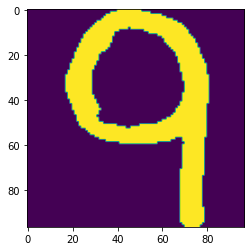

In [18]:
plt.imshow(training_img_as_obj_list[5].get_image())

**Resizing the image**

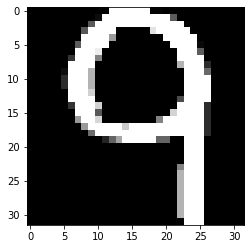

In [19]:
img = training_img_as_obj_list[5].get_image()
img = cv.resize(img,(32,32))
plt.imshow(img,cmap=plt.get_cmap('gray'))

**Applying Gaussian Blur**

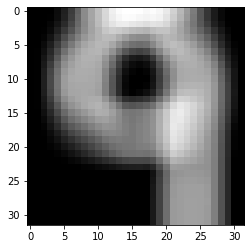

In [20]:
im_g = cv.GaussianBlur(img,(9,9),10)
plt.imshow(im_g,cmap=plt.get_cmap('gray'))

**Applying addWeighted method**

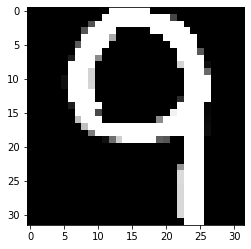

In [22]:
im_w = cv.addWeighted(img, 1.5, im_g, -0.5, 0,img)
plt.imshow(im_w,cmap=plt.get_cmap('gray'))

**Applying the kernel method**

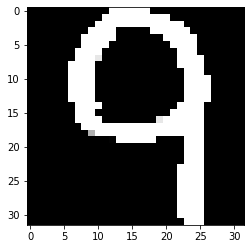

In [23]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
im_k = cv.filter2D(im_w, -1, kernel)
plt.imshow(im_k,cmap=plt.get_cmap('gray'))

# Function for filtering

In [65]:
# function to resize and convert it into numpy array

def fillter_img(image_obj_list,img_size):
    
    img_np = []
    for i in range(len(image_obj_list)):
        img = cv.resize(image_obj_list[i].get_image(),(img_size,img_size))    
        img_guass = cv.GaussianBlur(img,(9,9),10)          # will denoise it
        img_weighted = cv.addWeighted(img, 1.5, img_guass, -0.5, 0,img)  # combining the image with guassian blur
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) #filter
        img = cv.filter2D(img_weighted, -1, kernel)  # filter apply
        
        img = img.reshape(img_size,img_size,1).astype('float32')         # reshape the numpy array taking only one color channel
        
        img_np.append(img)
        
        
        # for printing
        print('processed {}/{}'.format(i+1,len(image_obj_list)),end='\r')
    
    img_np = np.array(img_np)
    return img_np

In [66]:
X_train = fillter_img(training_img_as_obj_list,32)

processed 1/72045
processed 2/72045
processed 3/72045
processed 4/72045
processed 5/72045
processed 6/72045
processed 7/72045
processed 8/72045
processed 9/72045
processed 10/72045
processed 11/72045
processed 12/72045
processed 13/72045
processed 14/72045
processed 15/72045
processed 16/72045
processed 17/72045
processed 18/72045
processed 19/72045
processed 20/72045
processed 21/72045
processed 22/72045
processed 23/72045
processed 24/72045
processed 25/72045
processed 26/72045
processed 27/72045
processed 28/72045
processed 29/72045
processed 30/72045
processed 31/72045
processed 32/72045
processed 33/72045
processed 34/72045
processed 35/72045
processed 36/72045
processed 37/72045
processed 38/72045
processed 39/72045
processed 40/72045
processed 41/72045
processed 42/72045
processed 43/72045
processed 44/72045
processed 45/72045
processed 46/72045
processed 47/72045
processed 48/72045
processed 49/72045
processed 50/72045
processed 51/72045
processed 52/72045
processed 53/72045
pr

processed 1103/72045
processed 1104/72045
processed 1105/72045
processed 1106/72045
processed 1107/72045
processed 1108/72045
processed 1109/72045
processed 1110/72045
processed 1111/72045
processed 1112/72045
processed 1113/72045
processed 1114/72045
processed 1115/72045
processed 1116/72045
processed 1117/72045
processed 1118/72045
processed 1119/72045
processed 1120/72045
processed 1121/72045
processed 1122/72045
processed 1123/72045
processed 1124/72045
processed 1125/72045
processed 1126/72045
processed 1127/72045
processed 1128/72045
processed 1129/72045
processed 1130/72045
processed 1131/72045
processed 1132/72045
processed 1133/72045
processed 1134/72045
processed 1135/72045
processed 1136/72045
processed 1137/72045
processed 1138/72045
processed 1139/72045
processed 1140/72045
processed 1141/72045
processed 1142/72045
processed 1143/72045
processed 1144/72045
processed 1145/72045
processed 1146/72045
processed 1147/72045
processed 1148/72045
processed 1149/72045
processed 115

processed 2332/72045
processed 2333/72045
processed 2334/72045
processed 2335/72045
processed 2336/72045
processed 2337/72045
processed 2338/72045
processed 2339/72045
processed 2340/72045
processed 2341/72045
processed 2342/72045
processed 2343/72045
processed 2344/72045
processed 2345/72045
processed 2346/72045
processed 2347/72045
processed 2348/72045
processed 2349/72045
processed 2350/72045
processed 2351/72045
processed 2352/72045
processed 2353/72045
processed 2354/72045
processed 2355/72045
processed 2356/72045
processed 2357/72045
processed 2358/72045
processed 2359/72045
processed 2360/72045
processed 2361/72045
processed 2362/72045
processed 2363/72045
processed 2364/72045
processed 2365/72045
processed 2366/72045
processed 2367/72045
processed 2368/72045
processed 2369/72045
processed 2370/72045
processed 2371/72045
processed 2372/72045
processed 2373/72045
processed 2374/72045
processed 2375/72045
processed 2376/72045
processed 2377/72045
processed 2378/72045
processed 237

processed 3606/72045
processed 3607/72045
processed 3608/72045
processed 3609/72045
processed 3610/72045
processed 3611/72045
processed 3612/72045
processed 3613/72045
processed 3614/72045
processed 3615/72045
processed 3616/72045
processed 3617/72045
processed 3618/72045
processed 3619/72045
processed 3620/72045
processed 3621/72045
processed 3622/72045
processed 3623/72045
processed 3624/72045
processed 3625/72045
processed 3626/72045
processed 3627/72045
processed 3628/72045
processed 3629/72045
processed 3630/72045
processed 3631/72045
processed 3632/72045
processed 3633/72045
processed 3634/72045
processed 3635/72045
processed 3636/72045
processed 3637/72045
processed 3638/72045
processed 3639/72045
processed 3640/72045
processed 3641/72045
processed 3642/72045
processed 3643/72045
processed 3644/72045
processed 3645/72045
processed 3646/72045
processed 3647/72045
processed 3648/72045
processed 3649/72045
processed 3650/72045
processed 3651/72045
processed 3652/72045
processed 365

processed 4978/72045
processed 4979/72045
processed 4980/72045
processed 4981/72045
processed 4982/72045
processed 4983/72045
processed 4984/72045
processed 4985/72045
processed 4986/72045
processed 4987/72045
processed 4988/72045
processed 4989/72045
processed 4990/72045
processed 4991/72045
processed 4992/72045
processed 4993/72045
processed 4994/72045
processed 4995/72045
processed 4996/72045
processed 4997/72045
processed 4998/72045
processed 4999/72045
processed 5000/72045
processed 5001/72045
processed 5002/72045
processed 5003/72045
processed 5004/72045
processed 5005/72045
processed 5006/72045
processed 5007/72045
processed 5008/72045
processed 5009/72045
processed 5010/72045
processed 5011/72045
processed 5012/72045
processed 5013/72045
processed 5014/72045
processed 5015/72045
processed 5016/72045
processed 5017/72045
processed 5018/72045
processed 5019/72045
processed 5020/72045
processed 5021/72045
processed 5022/72045
processed 5023/72045
processed 5024/72045
processed 502

processed 6288/72045
processed 6289/72045
processed 6290/72045
processed 6291/72045
processed 6292/72045
processed 6293/72045
processed 6294/72045
processed 6295/72045
processed 6296/72045
processed 6297/72045
processed 6298/72045
processed 6299/72045
processed 6300/72045
processed 6301/72045
processed 6302/72045
processed 6303/72045
processed 6304/72045
processed 6305/72045
processed 6306/72045
processed 6307/72045
processed 6308/72045
processed 6309/72045
processed 6310/72045
processed 6311/72045
processed 6312/72045
processed 6313/72045
processed 6314/72045
processed 6315/72045
processed 6316/72045
processed 6317/72045
processed 6318/72045
processed 6319/72045
processed 6320/72045
processed 6321/72045
processed 6322/72045
processed 6323/72045
processed 6324/72045
processed 6325/72045
processed 6326/72045
processed 6327/72045
processed 6328/72045
processed 6329/72045
processed 6330/72045
processed 6331/72045
processed 6332/72045
processed 6333/72045
processed 6334/72045
processed 633

processed 7228/72045
processed 7229/72045
processed 7230/72045
processed 7231/72045
processed 7232/72045
processed 7233/72045
processed 7234/72045
processed 7235/72045
processed 7236/72045
processed 7237/72045
processed 7238/72045
processed 7239/72045
processed 7240/72045
processed 7241/72045
processed 7242/72045
processed 7243/72045
processed 7244/72045
processed 7245/72045
processed 7246/72045
processed 7247/72045
processed 7248/72045
processed 7249/72045
processed 7250/72045
processed 7251/72045
processed 7252/72045
processed 7253/72045
processed 7254/72045
processed 7255/72045
processed 7256/72045
processed 7257/72045
processed 7258/72045
processed 7259/72045
processed 7260/72045
processed 7261/72045
processed 7262/72045
processed 7263/72045
processed 7264/72045
processed 7265/72045
processed 7266/72045
processed 7267/72045
processed 7268/72045
processed 7269/72045
processed 7270/72045
processed 7271/72045
processed 7272/72045
processed 7273/72045
processed 7274/72045
processed 727

processed 8171/72045
processed 8172/72045
processed 8173/72045
processed 8174/72045
processed 8175/72045
processed 8176/72045
processed 8177/72045
processed 8178/72045
processed 8179/72045
processed 8180/72045
processed 8181/72045
processed 8182/72045
processed 8183/72045
processed 8184/72045
processed 8185/72045
processed 8186/72045
processed 8187/72045
processed 8188/72045
processed 8189/72045
processed 8190/72045
processed 8191/72045
processed 8192/72045
processed 8193/72045
processed 8194/72045
processed 8195/72045
processed 8196/72045
processed 8197/72045
processed 8198/72045
processed 8199/72045
processed 8200/72045
processed 8201/72045
processed 8202/72045
processed 8203/72045
processed 8204/72045
processed 8205/72045
processed 8206/72045
processed 8207/72045
processed 8208/72045
processed 8209/72045
processed 8210/72045
processed 8211/72045
processed 8212/72045
processed 8213/72045
processed 8214/72045
processed 8215/72045
processed 8216/72045
processed 8217/72045
processed 821

processed 9188/72045
processed 9189/72045
processed 9190/72045
processed 9191/72045
processed 9192/72045
processed 9193/72045
processed 9194/72045
processed 9195/72045
processed 9196/72045
processed 9197/72045
processed 9198/72045
processed 9199/72045
processed 9200/72045
processed 9201/72045
processed 9202/72045
processed 9203/72045
processed 9204/72045
processed 9205/72045
processed 9206/72045
processed 9207/72045
processed 9208/72045
processed 9209/72045
processed 9210/72045
processed 9211/72045
processed 9212/72045
processed 9213/72045
processed 9214/72045
processed 9215/72045
processed 9216/72045
processed 9217/72045
processed 9218/72045
processed 9219/72045
processed 9220/72045
processed 9221/72045
processed 9222/72045
processed 9223/72045
processed 9224/72045
processed 9225/72045
processed 9226/72045
processed 9227/72045
processed 9228/72045
processed 9229/72045
processed 9230/72045
processed 9231/72045
processed 9232/72045
processed 9233/72045
processed 9234/72045
processed 923

processed 10644/72045
processed 10645/72045
processed 10646/72045
processed 10647/72045
processed 10648/72045
processed 10649/72045
processed 10650/72045
processed 10651/72045
processed 10652/72045
processed 10653/72045
processed 10654/72045
processed 10655/72045
processed 10656/72045
processed 10657/72045
processed 10658/72045
processed 10659/72045
processed 10660/72045
processed 10661/72045
processed 10662/72045
processed 10663/72045
processed 10664/72045
processed 10665/72045
processed 10666/72045
processed 10667/72045
processed 10668/72045
processed 10669/72045
processed 10670/72045
processed 10671/72045
processed 10672/72045
processed 10673/72045
processed 10674/72045
processed 10675/72045
processed 10676/72045
processed 10677/72045
processed 10678/72045
processed 10679/72045
processed 10680/72045
processed 10681/72045
processed 10682/72045
processed 10683/72045
processed 10684/72045
processed 10685/72045
processed 10686/72045
processed 10687/72045
processed 10688/72045
processed 

processed 11951/72045
processed 11952/72045
processed 11953/72045
processed 11954/72045
processed 11955/72045
processed 11956/72045
processed 11957/72045
processed 11958/72045
processed 11959/72045
processed 11960/72045
processed 11961/72045
processed 11962/72045
processed 11963/72045
processed 11964/72045
processed 11965/72045
processed 11966/72045
processed 11967/72045
processed 11968/72045
processed 11969/72045
processed 11970/72045
processed 11971/72045
processed 11972/72045
processed 11973/72045
processed 11974/72045
processed 11975/72045
processed 11976/72045
processed 11977/72045
processed 11978/72045
processed 11979/72045
processed 11980/72045
processed 11981/72045
processed 11982/72045
processed 11983/72045
processed 11984/72045
processed 11985/72045
processed 11986/72045
processed 11987/72045
processed 11988/72045
processed 11989/72045
processed 11990/72045
processed 11991/72045
processed 11992/72045
processed 11993/72045
processed 11994/72045
processed 11995/72045
processed 

processed 13243/72045
processed 13244/72045
processed 13245/72045
processed 13246/72045
processed 13247/72045
processed 13248/72045
processed 13249/72045
processed 13250/72045
processed 13251/72045
processed 13252/72045
processed 13253/72045
processed 13254/72045
processed 13255/72045
processed 13256/72045
processed 13257/72045
processed 13258/72045
processed 13259/72045
processed 13260/72045
processed 13261/72045
processed 13262/72045
processed 13263/72045
processed 13264/72045
processed 13265/72045
processed 13266/72045
processed 13267/72045
processed 13268/72045
processed 13269/72045
processed 13270/72045
processed 13271/72045
processed 13272/72045
processed 13273/72045
processed 13274/72045
processed 13275/72045
processed 13276/72045
processed 13277/72045
processed 13278/72045
processed 13279/72045
processed 13280/72045
processed 13281/72045
processed 13282/72045
processed 13283/72045
processed 13284/72045
processed 13285/72045
processed 13286/72045
processed 13287/72045
processed 

processed 14540/72045
processed 14541/72045
processed 14542/72045
processed 14543/72045
processed 14544/72045
processed 14545/72045
processed 14546/72045
processed 14547/72045
processed 14548/72045
processed 14549/72045
processed 14550/72045
processed 14551/72045
processed 14552/72045
processed 14553/72045
processed 14554/72045
processed 14555/72045
processed 14556/72045
processed 14557/72045
processed 14558/72045
processed 14559/72045
processed 14560/72045
processed 14561/72045
processed 14562/72045
processed 14563/72045
processed 14564/72045
processed 14565/72045
processed 14566/72045
processed 14567/72045
processed 14568/72045
processed 14569/72045
processed 14570/72045
processed 14571/72045
processed 14572/72045
processed 14573/72045
processed 14574/72045
processed 14575/72045
processed 14576/72045
processed 14577/72045
processed 14578/72045
processed 14579/72045
processed 14580/72045
processed 14581/72045
processed 14582/72045
processed 14583/72045
processed 14584/72045
processed 

processed 15632/72045
processed 15633/72045
processed 15634/72045
processed 15635/72045
processed 15636/72045
processed 15637/72045
processed 15638/72045
processed 15639/72045
processed 15640/72045
processed 15641/72045
processed 15642/72045
processed 15643/72045
processed 15644/72045
processed 15645/72045
processed 15646/72045
processed 15647/72045
processed 15648/72045
processed 15649/72045
processed 15650/72045
processed 15651/72045
processed 15652/72045
processed 15653/72045
processed 15654/72045
processed 15655/72045
processed 15656/72045
processed 15657/72045
processed 15658/72045
processed 15659/72045
processed 15660/72045
processed 15661/72045
processed 15662/72045
processed 15663/72045
processed 15664/72045
processed 15665/72045
processed 15666/72045
processed 15667/72045
processed 15668/72045
processed 15669/72045
processed 15670/72045
processed 15671/72045
processed 15672/72045
processed 15673/72045
processed 15674/72045
processed 15675/72045
processed 15676/72045
processed 

processed 17037/72045
processed 17038/72045
processed 17039/72045
processed 17040/72045
processed 17041/72045
processed 17042/72045
processed 17043/72045
processed 17044/72045
processed 17045/72045
processed 17046/72045
processed 17047/72045
processed 17048/72045
processed 17049/72045
processed 17050/72045
processed 17051/72045
processed 17052/72045
processed 17053/72045
processed 17054/72045
processed 17055/72045
processed 17056/72045
processed 17057/72045
processed 17058/72045
processed 17059/72045
processed 17060/72045
processed 17061/72045
processed 17062/72045
processed 17063/72045
processed 17064/72045
processed 17065/72045
processed 17066/72045
processed 17067/72045
processed 17068/72045
processed 17069/72045
processed 17070/72045
processed 17071/72045
processed 17072/72045
processed 17073/72045
processed 17074/72045
processed 17075/72045
processed 17076/72045
processed 17077/72045
processed 17078/72045
processed 17079/72045
processed 17080/72045
processed 17081/72045
processed 

processed 18071/72045
processed 18072/72045
processed 18073/72045
processed 18074/72045
processed 18075/72045
processed 18076/72045
processed 18077/72045
processed 18078/72045
processed 18079/72045
processed 18080/72045
processed 18081/72045
processed 18082/72045
processed 18083/72045
processed 18084/72045
processed 18085/72045
processed 18086/72045
processed 18087/72045
processed 18088/72045
processed 18089/72045
processed 18090/72045
processed 18091/72045
processed 18092/72045
processed 18093/72045
processed 18094/72045
processed 18095/72045
processed 18096/72045
processed 18097/72045
processed 18098/72045
processed 18099/72045
processed 18100/72045
processed 18101/72045
processed 18102/72045
processed 18103/72045
processed 18104/72045
processed 18105/72045
processed 18106/72045
processed 18107/72045
processed 18108/72045
processed 18109/72045
processed 18110/72045
processed 18111/72045
processed 18112/72045
processed 18113/72045
processed 18114/72045
processed 18115/72045
processed 

processed 19269/72045
processed 19270/72045
processed 19271/72045
processed 19272/72045
processed 19273/72045
processed 19274/72045
processed 19275/72045
processed 19276/72045
processed 19277/72045
processed 19278/72045
processed 19279/72045
processed 19280/72045
processed 19281/72045
processed 19282/72045
processed 19283/72045
processed 19284/72045
processed 19285/72045
processed 19286/72045
processed 19287/72045
processed 19288/72045
processed 19289/72045
processed 19290/72045
processed 19291/72045
processed 19292/72045
processed 19293/72045
processed 19294/72045
processed 19295/72045
processed 19296/72045
processed 19297/72045
processed 19298/72045
processed 19299/72045
processed 19300/72045
processed 19301/72045
processed 19302/72045
processed 19303/72045
processed 19304/72045
processed 19305/72045
processed 19306/72045
processed 19307/72045
processed 19308/72045
processed 19309/72045
processed 19310/72045
processed 19311/72045
processed 19312/72045
processed 19313/72045
processed 

processed 20761/72045
processed 20762/72045
processed 20763/72045
processed 20764/72045
processed 20765/72045
processed 20766/72045
processed 20767/72045
processed 20768/72045
processed 20769/72045
processed 20770/72045
processed 20771/72045
processed 20772/72045
processed 20773/72045
processed 20774/72045
processed 20775/72045
processed 20776/72045
processed 20777/72045
processed 20778/72045
processed 20779/72045
processed 20780/72045
processed 20781/72045
processed 20782/72045
processed 20783/72045
processed 20784/72045
processed 20785/72045
processed 20786/72045
processed 20787/72045
processed 20788/72045
processed 20789/72045
processed 20790/72045
processed 20791/72045
processed 20792/72045
processed 20793/72045
processed 20794/72045
processed 20795/72045
processed 20796/72045
processed 20797/72045
processed 20798/72045
processed 20799/72045
processed 20800/72045
processed 20801/72045
processed 20802/72045
processed 20803/72045
processed 20804/72045
processed 20805/72045
processed 

processed 21761/72045
processed 21762/72045
processed 21763/72045
processed 21764/72045
processed 21765/72045
processed 21766/72045
processed 21767/72045
processed 21768/72045
processed 21769/72045
processed 21770/72045
processed 21771/72045
processed 21772/72045
processed 21773/72045
processed 21774/72045
processed 21775/72045
processed 21776/72045
processed 21777/72045
processed 21778/72045
processed 21779/72045
processed 21780/72045
processed 21781/72045
processed 21782/72045
processed 21783/72045
processed 21784/72045
processed 21785/72045
processed 21786/72045
processed 21787/72045
processed 21788/72045
processed 21789/72045
processed 21790/72045
processed 21791/72045
processed 21792/72045
processed 21793/72045
processed 21794/72045
processed 21795/72045
processed 21796/72045
processed 21797/72045
processed 21798/72045
processed 21799/72045
processed 21800/72045
processed 21801/72045
processed 21802/72045
processed 21803/72045
processed 21804/72045
processed 21805/72045
processed 

processed 23068/72045
processed 23069/72045
processed 23070/72045
processed 23071/72045
processed 23072/72045
processed 23073/72045
processed 23074/72045
processed 23075/72045
processed 23076/72045
processed 23077/72045
processed 23078/72045
processed 23079/72045
processed 23080/72045
processed 23081/72045
processed 23082/72045
processed 23083/72045
processed 23084/72045
processed 23085/72045
processed 23086/72045
processed 23087/72045
processed 23088/72045
processed 23089/72045
processed 23090/72045
processed 23091/72045
processed 23092/72045
processed 23093/72045
processed 23094/72045
processed 23095/72045
processed 23096/72045
processed 23097/72045
processed 23098/72045
processed 23099/72045
processed 23100/72045
processed 23101/72045
processed 23102/72045
processed 23103/72045
processed 23104/72045
processed 23105/72045
processed 23106/72045
processed 23107/72045
processed 23108/72045
processed 23109/72045
processed 23110/72045
processed 23111/72045
processed 23112/72045
processed 

processed 24360/72045
processed 24361/72045
processed 24362/72045
processed 24363/72045
processed 24364/72045
processed 24365/72045
processed 24366/72045
processed 24367/72045
processed 24368/72045
processed 24369/72045
processed 24370/72045
processed 24371/72045
processed 24372/72045
processed 24373/72045
processed 24374/72045
processed 24375/72045
processed 24376/72045
processed 24377/72045
processed 24378/72045
processed 24379/72045
processed 24380/72045
processed 24381/72045
processed 24382/72045
processed 24383/72045
processed 24384/72045
processed 24385/72045
processed 24386/72045
processed 24387/72045
processed 24388/72045
processed 24389/72045
processed 24390/72045
processed 24391/72045
processed 24392/72045
processed 24393/72045
processed 24394/72045
processed 24395/72045
processed 24396/72045
processed 24397/72045
processed 24398/72045
processed 24399/72045
processed 24400/72045
processed 24401/72045
processed 24402/72045
processed 24403/72045
processed 24404/72045
processed 

processed 25362/72045
processed 25363/72045
processed 25364/72045
processed 25365/72045
processed 25366/72045
processed 25367/72045
processed 25368/72045
processed 25369/72045
processed 25370/72045
processed 25371/72045
processed 25372/72045
processed 25373/72045
processed 25374/72045
processed 25375/72045
processed 25376/72045
processed 25377/72045
processed 25378/72045
processed 25379/72045
processed 25380/72045
processed 25381/72045
processed 25382/72045
processed 25383/72045
processed 25384/72045
processed 25385/72045
processed 25386/72045
processed 25387/72045
processed 25388/72045
processed 25389/72045
processed 25390/72045
processed 25391/72045
processed 25392/72045
processed 25393/72045
processed 25394/72045
processed 25395/72045
processed 25396/72045
processed 25397/72045
processed 25398/72045
processed 25399/72045
processed 25400/72045
processed 25401/72045
processed 25402/72045
processed 25403/72045
processed 25404/72045
processed 25405/72045
processed 25406/72045
processed 

processed 26633/72045
processed 26634/72045
processed 26635/72045
processed 26636/72045
processed 26637/72045
processed 26638/72045
processed 26639/72045
processed 26640/72045
processed 26641/72045
processed 26642/72045
processed 26643/72045
processed 26644/72045
processed 26645/72045
processed 26646/72045
processed 26647/72045
processed 26648/72045
processed 26649/72045
processed 26650/72045
processed 26651/72045
processed 26652/72045
processed 26653/72045
processed 26654/72045
processed 26655/72045
processed 26656/72045
processed 26657/72045
processed 26658/72045
processed 26659/72045
processed 26660/72045
processed 26661/72045
processed 26662/72045
processed 26663/72045
processed 26664/72045
processed 26665/72045
processed 26666/72045
processed 26667/72045
processed 26668/72045
processed 26669/72045
processed 26670/72045
processed 26671/72045
processed 26672/72045
processed 26673/72045
processed 26674/72045
processed 26675/72045
processed 26676/72045
processed 26677/72045
processed 

processed 27835/72045
processed 27836/72045
processed 27837/72045
processed 27838/72045
processed 27839/72045
processed 27840/72045
processed 27841/72045
processed 27842/72045
processed 27843/72045
processed 27844/72045
processed 27845/72045
processed 27846/72045
processed 27847/72045
processed 27848/72045
processed 27849/72045
processed 27850/72045
processed 27851/72045
processed 27852/72045
processed 27853/72045
processed 27854/72045
processed 27855/72045
processed 27856/72045
processed 27857/72045
processed 27858/72045
processed 27859/72045
processed 27860/72045
processed 27861/72045
processed 27862/72045
processed 27863/72045
processed 27864/72045
processed 27865/72045
processed 27866/72045
processed 27867/72045
processed 27868/72045
processed 27869/72045
processed 27870/72045
processed 27871/72045
processed 27872/72045
processed 27873/72045
processed 27874/72045
processed 27875/72045
processed 27876/72045
processed 27877/72045
processed 27878/72045
processed 27879/72045
processed 

processed 29079/72045
processed 29080/72045
processed 29081/72045
processed 29082/72045
processed 29083/72045
processed 29084/72045
processed 29085/72045
processed 29086/72045
processed 29087/72045
processed 29088/72045
processed 29089/72045
processed 29090/72045
processed 29091/72045
processed 29092/72045
processed 29093/72045
processed 29094/72045
processed 29095/72045
processed 29096/72045
processed 29097/72045
processed 29098/72045
processed 29099/72045
processed 29100/72045
processed 29101/72045
processed 29102/72045
processed 29103/72045
processed 29104/72045
processed 29105/72045
processed 29106/72045
processed 29107/72045
processed 29108/72045
processed 29109/72045
processed 29110/72045
processed 29111/72045
processed 29112/72045
processed 29113/72045
processed 29114/72045
processed 29115/72045
processed 29116/72045
processed 29117/72045
processed 29118/72045
processed 29119/72045
processed 29120/72045
processed 29121/72045
processed 29122/72045
processed 29123/72045
processed 

processed 30244/72045
processed 30245/72045
processed 30246/72045
processed 30247/72045
processed 30248/72045
processed 30249/72045
processed 30250/72045
processed 30251/72045
processed 30252/72045
processed 30253/72045
processed 30254/72045
processed 30255/72045
processed 30256/72045
processed 30257/72045
processed 30258/72045
processed 30259/72045
processed 30260/72045
processed 30261/72045
processed 30262/72045
processed 30263/72045
processed 30264/72045
processed 30265/72045
processed 30266/72045
processed 30267/72045
processed 30268/72045
processed 30269/72045
processed 30270/72045
processed 30271/72045
processed 30272/72045
processed 30273/72045
processed 30274/72045
processed 30275/72045
processed 30276/72045
processed 30277/72045
processed 30278/72045
processed 30279/72045
processed 30280/72045
processed 30281/72045
processed 30282/72045
processed 30283/72045
processed 30284/72045
processed 30285/72045
processed 30286/72045
processed 30287/72045
processed 30288/72045
processed 

processed 31382/72045
processed 31383/72045
processed 31384/72045
processed 31385/72045
processed 31386/72045
processed 31387/72045
processed 31388/72045
processed 31389/72045
processed 31390/72045
processed 31391/72045
processed 31392/72045
processed 31393/72045
processed 31394/72045
processed 31395/72045
processed 31396/72045
processed 31397/72045
processed 31398/72045
processed 31399/72045
processed 31400/72045
processed 31401/72045
processed 31402/72045
processed 31403/72045
processed 31404/72045
processed 31405/72045
processed 31406/72045
processed 31407/72045
processed 31408/72045
processed 31409/72045
processed 31410/72045
processed 31411/72045
processed 31412/72045
processed 31413/72045
processed 31414/72045
processed 31415/72045
processed 31416/72045
processed 31417/72045
processed 31418/72045
processed 31419/72045
processed 31420/72045
processed 31421/72045
processed 31422/72045
processed 31423/72045
processed 31424/72045
processed 31425/72045
processed 31426/72045
processed 

processed 32805/72045
processed 32806/72045
processed 32807/72045
processed 32808/72045
processed 32809/72045
processed 32810/72045
processed 32811/72045
processed 32812/72045
processed 32813/72045
processed 32814/72045
processed 32815/72045
processed 32816/72045
processed 32817/72045
processed 32818/72045
processed 32819/72045
processed 32820/72045
processed 32821/72045
processed 32822/72045
processed 32823/72045
processed 32824/72045
processed 32825/72045
processed 32826/72045
processed 32827/72045
processed 32828/72045
processed 32829/72045
processed 32830/72045
processed 32831/72045
processed 32832/72045
processed 32833/72045
processed 32834/72045
processed 32835/72045
processed 32836/72045
processed 32837/72045
processed 32838/72045
processed 32839/72045
processed 32840/72045
processed 32841/72045
processed 32842/72045
processed 32843/72045
processed 32844/72045
processed 32845/72045
processed 32846/72045
processed 32847/72045
processed 32848/72045
processed 32849/72045
processed 

processed 33988/72045
processed 33989/72045
processed 33990/72045
processed 33991/72045
processed 33992/72045
processed 33993/72045
processed 33994/72045
processed 33995/72045
processed 33996/72045
processed 33997/72045
processed 33998/72045
processed 33999/72045
processed 34000/72045
processed 34001/72045
processed 34002/72045
processed 34003/72045
processed 34004/72045
processed 34005/72045
processed 34006/72045
processed 34007/72045
processed 34008/72045
processed 34009/72045
processed 34010/72045
processed 34011/72045
processed 34012/72045
processed 34013/72045
processed 34014/72045
processed 34015/72045
processed 34016/72045
processed 34017/72045
processed 34018/72045
processed 34019/72045
processed 34020/72045
processed 34021/72045
processed 34022/72045
processed 34023/72045
processed 34024/72045
processed 34025/72045
processed 34026/72045
processed 34027/72045
processed 34028/72045
processed 34029/72045
processed 34030/72045
processed 34031/72045
processed 34032/72045
processed 

processed 35127/72045
processed 35128/72045
processed 35129/72045
processed 35130/72045
processed 35131/72045
processed 35132/72045
processed 35133/72045
processed 35134/72045
processed 35135/72045
processed 35136/72045
processed 35137/72045
processed 35138/72045
processed 35139/72045
processed 35140/72045
processed 35141/72045
processed 35142/72045
processed 35143/72045
processed 35144/72045
processed 35145/72045
processed 35146/72045
processed 35147/72045
processed 35148/72045
processed 35149/72045
processed 35150/72045
processed 35151/72045
processed 35152/72045
processed 35153/72045
processed 35154/72045
processed 35155/72045
processed 35156/72045
processed 35157/72045
processed 35158/72045
processed 35159/72045
processed 35160/72045
processed 35161/72045
processed 35162/72045
processed 35163/72045
processed 35164/72045
processed 35165/72045
processed 35166/72045
processed 35167/72045
processed 35168/72045
processed 35169/72045
processed 35170/72045
processed 35171/72045
processed 

processed 36381/72045
processed 36382/72045
processed 36383/72045
processed 36384/72045
processed 36385/72045
processed 36386/72045
processed 36387/72045
processed 36388/72045
processed 36389/72045
processed 36390/72045
processed 36391/72045
processed 36392/72045
processed 36393/72045
processed 36394/72045
processed 36395/72045
processed 36396/72045
processed 36397/72045
processed 36398/72045
processed 36399/72045
processed 36400/72045
processed 36401/72045
processed 36402/72045
processed 36403/72045
processed 36404/72045
processed 36405/72045
processed 36406/72045
processed 36407/72045
processed 36408/72045
processed 36409/72045
processed 36410/72045
processed 36411/72045
processed 36412/72045
processed 36413/72045
processed 36414/72045
processed 36415/72045
processed 36416/72045
processed 36417/72045
processed 36418/72045
processed 36419/72045
processed 36420/72045
processed 36421/72045
processed 36422/72045
processed 36423/72045
processed 36424/72045
processed 36425/72045
processed 

processed 37631/72045
processed 37632/72045
processed 37633/72045
processed 37634/72045
processed 37635/72045
processed 37636/72045
processed 37637/72045
processed 37638/72045
processed 37639/72045
processed 37640/72045
processed 37641/72045
processed 37642/72045
processed 37643/72045
processed 37644/72045
processed 37645/72045
processed 37646/72045
processed 37647/72045
processed 37648/72045
processed 37649/72045
processed 37650/72045
processed 37651/72045
processed 37652/72045
processed 37653/72045
processed 37654/72045
processed 37655/72045
processed 37656/72045
processed 37657/72045
processed 37658/72045
processed 37659/72045
processed 37660/72045
processed 37661/72045
processed 37662/72045
processed 37663/72045
processed 37664/72045
processed 37665/72045
processed 37666/72045
processed 37667/72045
processed 37668/72045
processed 37669/72045
processed 37670/72045
processed 37671/72045
processed 37672/72045
processed 37673/72045
processed 37674/72045
processed 37675/72045
processed 

processed 38907/72045
processed 38908/72045
processed 38909/72045
processed 38910/72045
processed 38911/72045
processed 38912/72045
processed 38913/72045
processed 38914/72045
processed 38915/72045
processed 38916/72045
processed 38917/72045
processed 38918/72045
processed 38919/72045
processed 38920/72045
processed 38921/72045
processed 38922/72045
processed 38923/72045
processed 38924/72045
processed 38925/72045
processed 38926/72045
processed 38927/72045
processed 38928/72045
processed 38929/72045
processed 38930/72045
processed 38931/72045
processed 38932/72045
processed 38933/72045
processed 38934/72045
processed 38935/72045
processed 38936/72045
processed 38937/72045
processed 38938/72045
processed 38939/72045
processed 38940/72045
processed 38941/72045
processed 38942/72045
processed 38943/72045
processed 38944/72045
processed 38945/72045
processed 38946/72045
processed 38947/72045
processed 38948/72045
processed 38949/72045
processed 38950/72045
processed 38951/72045
processed 

processed 40195/72045
processed 40196/72045
processed 40197/72045
processed 40198/72045
processed 40199/72045
processed 40200/72045
processed 40201/72045
processed 40202/72045
processed 40203/72045
processed 40204/72045
processed 40205/72045
processed 40206/72045
processed 40207/72045
processed 40208/72045
processed 40209/72045
processed 40210/72045
processed 40211/72045
processed 40212/72045
processed 40213/72045
processed 40214/72045
processed 40215/72045
processed 40216/72045
processed 40217/72045
processed 40218/72045
processed 40219/72045
processed 40220/72045
processed 40221/72045
processed 40222/72045
processed 40223/72045
processed 40224/72045
processed 40225/72045
processed 40226/72045
processed 40227/72045
processed 40228/72045
processed 40229/72045
processed 40230/72045
processed 40231/72045
processed 40232/72045
processed 40233/72045
processed 40234/72045
processed 40235/72045
processed 40236/72045
processed 40237/72045
processed 40238/72045
processed 40239/72045
processed 

processed 41334/72045
processed 41335/72045
processed 41336/72045
processed 41337/72045
processed 41338/72045
processed 41339/72045
processed 41340/72045
processed 41341/72045
processed 41342/72045
processed 41343/72045
processed 41344/72045
processed 41345/72045
processed 41346/72045
processed 41347/72045
processed 41348/72045
processed 41349/72045
processed 41350/72045
processed 41351/72045
processed 41352/72045
processed 41353/72045
processed 41354/72045
processed 41355/72045
processed 41356/72045
processed 41357/72045
processed 41358/72045
processed 41359/72045
processed 41360/72045
processed 41361/72045
processed 41362/72045
processed 41363/72045
processed 41364/72045
processed 41365/72045
processed 41366/72045
processed 41367/72045
processed 41368/72045
processed 41369/72045
processed 41370/72045
processed 41371/72045
processed 41372/72045
processed 41373/72045
processed 41374/72045
processed 41375/72045
processed 41376/72045
processed 41377/72045
processed 41378/72045
processed 

processed 42667/72045
processed 42668/72045
processed 42669/72045
processed 42670/72045
processed 42671/72045
processed 42672/72045
processed 42673/72045
processed 42674/72045
processed 42675/72045
processed 42676/72045
processed 42677/72045
processed 42678/72045
processed 42679/72045
processed 42680/72045
processed 42681/72045
processed 42682/72045
processed 42683/72045
processed 42684/72045
processed 42685/72045
processed 42686/72045
processed 42687/72045
processed 42688/72045
processed 42689/72045
processed 42690/72045
processed 42691/72045
processed 42692/72045
processed 42693/72045
processed 42694/72045
processed 42695/72045
processed 42696/72045
processed 42697/72045
processed 42698/72045
processed 42699/72045
processed 42700/72045
processed 42701/72045
processed 42702/72045
processed 42703/72045
processed 42704/72045
processed 42705/72045
processed 42706/72045
processed 42707/72045
processed 42708/72045
processed 42709/72045
processed 42710/72045
processed 42711/72045
processed 

processed 43968/72045
processed 43969/72045
processed 43970/72045
processed 43971/72045
processed 43972/72045
processed 43973/72045
processed 43974/72045
processed 43975/72045
processed 43976/72045
processed 43977/72045
processed 43978/72045
processed 43979/72045
processed 43980/72045
processed 43981/72045
processed 43982/72045
processed 43983/72045
processed 43984/72045
processed 43985/72045
processed 43986/72045
processed 43987/72045
processed 43988/72045
processed 43989/72045
processed 43990/72045
processed 43991/72045
processed 43992/72045
processed 43993/72045
processed 43994/72045
processed 43995/72045
processed 43996/72045
processed 43997/72045
processed 43998/72045
processed 43999/72045
processed 44000/72045
processed 44001/72045
processed 44002/72045
processed 44003/72045
processed 44004/72045
processed 44005/72045
processed 44006/72045
processed 44007/72045
processed 44008/72045
processed 44009/72045
processed 44010/72045
processed 44011/72045
processed 44012/72045
processed 

processed 45140/72045
processed 45141/72045
processed 45142/72045
processed 45143/72045
processed 45144/72045
processed 45145/72045
processed 45146/72045
processed 45147/72045
processed 45148/72045
processed 45149/72045
processed 45150/72045
processed 45151/72045
processed 45152/72045
processed 45153/72045
processed 45154/72045
processed 45155/72045
processed 45156/72045
processed 45157/72045
processed 45158/72045
processed 45159/72045
processed 45160/72045
processed 45161/72045
processed 45162/72045
processed 45163/72045
processed 45164/72045
processed 45165/72045
processed 45166/72045
processed 45167/72045
processed 45168/72045
processed 45169/72045
processed 45170/72045
processed 45171/72045
processed 45172/72045
processed 45173/72045
processed 45174/72045
processed 45175/72045
processed 45176/72045
processed 45177/72045
processed 45178/72045
processed 45179/72045
processed 45180/72045
processed 45181/72045
processed 45182/72045
processed 45183/72045
processed 45184/72045
processed 

processed 46282/72045
processed 46283/72045
processed 46284/72045
processed 46285/72045
processed 46286/72045
processed 46287/72045
processed 46288/72045
processed 46289/72045
processed 46290/72045
processed 46291/72045
processed 46292/72045
processed 46293/72045
processed 46294/72045
processed 46295/72045
processed 46296/72045
processed 46297/72045
processed 46298/72045
processed 46299/72045
processed 46300/72045
processed 46301/72045
processed 46302/72045
processed 46303/72045
processed 46304/72045
processed 46305/72045
processed 46306/72045
processed 46307/72045
processed 46308/72045
processed 46309/72045
processed 46310/72045
processed 46311/72045
processed 46312/72045
processed 46313/72045
processed 46314/72045
processed 46315/72045
processed 46316/72045
processed 46317/72045
processed 46318/72045
processed 46319/72045
processed 46320/72045
processed 46321/72045
processed 46322/72045
processed 46323/72045
processed 46324/72045
processed 46325/72045
processed 46326/72045
processed 

processed 47687/72045
processed 47688/72045
processed 47689/72045
processed 47690/72045
processed 47691/72045
processed 47692/72045
processed 47693/72045
processed 47694/72045
processed 47695/72045
processed 47696/72045
processed 47697/72045
processed 47698/72045
processed 47699/72045
processed 47700/72045
processed 47701/72045
processed 47702/72045
processed 47703/72045
processed 47704/72045
processed 47705/72045
processed 47706/72045
processed 47707/72045
processed 47708/72045
processed 47709/72045
processed 47710/72045
processed 47711/72045
processed 47712/72045
processed 47713/72045
processed 47714/72045
processed 47715/72045
processed 47716/72045
processed 47717/72045
processed 47718/72045
processed 47719/72045
processed 47720/72045
processed 47721/72045
processed 47722/72045
processed 47723/72045
processed 47724/72045
processed 47725/72045
processed 47726/72045
processed 47727/72045
processed 47728/72045
processed 47729/72045
processed 47730/72045
processed 47731/72045
processed 

processed 48969/72045
processed 48970/72045
processed 48971/72045
processed 48972/72045
processed 48973/72045
processed 48974/72045
processed 48975/72045
processed 48976/72045
processed 48977/72045
processed 48978/72045
processed 48979/72045
processed 48980/72045
processed 48981/72045
processed 48982/72045
processed 48983/72045
processed 48984/72045
processed 48985/72045
processed 48986/72045
processed 48987/72045
processed 48988/72045
processed 48989/72045
processed 48990/72045
processed 48991/72045
processed 48992/72045
processed 48993/72045
processed 48994/72045
processed 48995/72045
processed 48996/72045
processed 48997/72045
processed 48998/72045
processed 48999/72045
processed 49000/72045
processed 49001/72045
processed 49002/72045
processed 49003/72045
processed 49004/72045
processed 49005/72045
processed 49006/72045
processed 49007/72045
processed 49008/72045
processed 49009/72045
processed 49010/72045
processed 49011/72045
processed 49012/72045
processed 49013/72045
processed 

processed 50282/72045
processed 50283/72045
processed 50284/72045
processed 50285/72045
processed 50286/72045
processed 50287/72045
processed 50288/72045
processed 50289/72045
processed 50290/72045
processed 50291/72045
processed 50292/72045
processed 50293/72045
processed 50294/72045
processed 50295/72045
processed 50296/72045
processed 50297/72045
processed 50298/72045
processed 50299/72045
processed 50300/72045
processed 50301/72045
processed 50302/72045
processed 50303/72045
processed 50304/72045
processed 50305/72045
processed 50306/72045
processed 50307/72045
processed 50308/72045
processed 50309/72045
processed 50310/72045
processed 50311/72045
processed 50312/72045
processed 50313/72045
processed 50314/72045
processed 50315/72045
processed 50316/72045
processed 50317/72045
processed 50318/72045
processed 50319/72045
processed 50320/72045
processed 50321/72045
processed 50322/72045
processed 50323/72045
processed 50324/72045
processed 50325/72045
processed 50326/72045
processed 

processed 51731/72045
processed 51732/72045
processed 51733/72045
processed 51734/72045
processed 51735/72045
processed 51736/72045
processed 51737/72045
processed 51738/72045
processed 51739/72045
processed 51740/72045
processed 51741/72045
processed 51742/72045
processed 51743/72045
processed 51744/72045
processed 51745/72045
processed 51746/72045
processed 51747/72045
processed 51748/72045
processed 51749/72045
processed 51750/72045
processed 51751/72045
processed 51752/72045
processed 51753/72045
processed 51754/72045
processed 51755/72045
processed 51756/72045
processed 51757/72045
processed 51758/72045
processed 51759/72045
processed 51760/72045
processed 51761/72045
processed 51762/72045
processed 51763/72045
processed 51764/72045
processed 51765/72045
processed 51766/72045
processed 51767/72045
processed 51768/72045
processed 51769/72045
processed 51770/72045
processed 51771/72045
processed 51772/72045
processed 51773/72045
processed 51774/72045
processed 51775/72045
processed 

processed 53027/72045
processed 53028/72045
processed 53029/72045
processed 53030/72045
processed 53031/72045
processed 53032/72045
processed 53033/72045
processed 53034/72045
processed 53035/72045
processed 53036/72045
processed 53037/72045
processed 53038/72045
processed 53039/72045
processed 53040/72045
processed 53041/72045
processed 53042/72045
processed 53043/72045
processed 53044/72045
processed 53045/72045
processed 53046/72045
processed 53047/72045
processed 53048/72045
processed 53049/72045
processed 53050/72045
processed 53051/72045
processed 53052/72045
processed 53053/72045
processed 53054/72045
processed 53055/72045
processed 53056/72045
processed 53057/72045
processed 53058/72045
processed 53059/72045
processed 53060/72045
processed 53061/72045
processed 53062/72045
processed 53063/72045
processed 53064/72045
processed 53065/72045
processed 53066/72045
processed 53067/72045
processed 53068/72045
processed 53069/72045
processed 53070/72045
processed 53071/72045
processed 

processed 54013/72045
processed 54014/72045
processed 54015/72045
processed 54016/72045
processed 54017/72045
processed 54018/72045
processed 54019/72045
processed 54020/72045
processed 54021/72045
processed 54022/72045
processed 54023/72045
processed 54024/72045
processed 54025/72045
processed 54026/72045
processed 54027/72045
processed 54028/72045
processed 54029/72045
processed 54030/72045
processed 54031/72045
processed 54032/72045
processed 54033/72045
processed 54034/72045
processed 54035/72045
processed 54036/72045
processed 54037/72045
processed 54038/72045
processed 54039/72045
processed 54040/72045
processed 54041/72045
processed 54042/72045
processed 54043/72045
processed 54044/72045
processed 54045/72045
processed 54046/72045
processed 54047/72045
processed 54048/72045
processed 54049/72045
processed 54050/72045
processed 54051/72045
processed 54052/72045
processed 54053/72045
processed 54054/72045
processed 54055/72045
processed 54056/72045
processed 54057/72045
processed 

processed 54663/72045
processed 54664/72045
processed 54665/72045
processed 54666/72045
processed 54667/72045
processed 54668/72045
processed 54669/72045
processed 54670/72045
processed 54671/72045
processed 54672/72045
processed 54673/72045
processed 54674/72045
processed 54675/72045
processed 54676/72045
processed 54677/72045
processed 54678/72045
processed 54679/72045
processed 54680/72045
processed 54681/72045
processed 54682/72045
processed 54683/72045
processed 54684/72045
processed 54685/72045
processed 54686/72045
processed 54687/72045
processed 54688/72045
processed 54689/72045
processed 54690/72045
processed 54691/72045
processed 54692/72045
processed 54693/72045
processed 54694/72045
processed 54695/72045
processed 54696/72045
processed 54697/72045
processed 54698/72045
processed 54699/72045
processed 54700/72045
processed 54701/72045
processed 54702/72045
processed 54703/72045
processed 54704/72045
processed 54705/72045
processed 54706/72045
processed 54707/72045
processed 

processed 55290/72045
processed 55291/72045
processed 55292/72045
processed 55293/72045
processed 55294/72045
processed 55295/72045
processed 55296/72045
processed 55297/72045
processed 55298/72045
processed 55299/72045
processed 55300/72045
processed 55301/72045
processed 55302/72045
processed 55303/72045
processed 55304/72045
processed 55305/72045
processed 55306/72045
processed 55307/72045
processed 55308/72045
processed 55309/72045
processed 55310/72045
processed 55311/72045
processed 55312/72045
processed 55313/72045
processed 55314/72045
processed 55315/72045
processed 55316/72045
processed 55317/72045
processed 55318/72045
processed 55319/72045
processed 55320/72045
processed 55321/72045
processed 55322/72045
processed 55323/72045
processed 55324/72045
processed 55325/72045
processed 55326/72045
processed 55327/72045
processed 55328/72045
processed 55329/72045
processed 55330/72045
processed 55331/72045
processed 55332/72045
processed 55333/72045
processed 55334/72045
processed 

processed 56050/72045
processed 56051/72045
processed 56052/72045
processed 56053/72045
processed 56054/72045
processed 56055/72045
processed 56056/72045
processed 56057/72045
processed 56058/72045
processed 56059/72045
processed 56060/72045
processed 56061/72045
processed 56062/72045
processed 56063/72045
processed 56064/72045
processed 56065/72045
processed 56066/72045
processed 56067/72045
processed 56068/72045
processed 56069/72045
processed 56070/72045
processed 56071/72045
processed 56072/72045
processed 56073/72045
processed 56074/72045
processed 56075/72045
processed 56076/72045
processed 56077/72045
processed 56078/72045
processed 56079/72045
processed 56080/72045
processed 56081/72045
processed 56082/72045
processed 56083/72045
processed 56084/72045
processed 56085/72045
processed 56086/72045
processed 56087/72045
processed 56088/72045
processed 56089/72045
processed 56090/72045
processed 56091/72045
processed 56092/72045
processed 56093/72045
processed 56094/72045
processed 

processed 57243/72045
processed 57244/72045
processed 57245/72045
processed 57246/72045
processed 57247/72045
processed 57248/72045
processed 57249/72045
processed 57250/72045
processed 57251/72045
processed 57252/72045
processed 57253/72045
processed 57254/72045
processed 57255/72045
processed 57256/72045
processed 57257/72045
processed 57258/72045
processed 57259/72045
processed 57260/72045
processed 57261/72045
processed 57262/72045
processed 57263/72045
processed 57264/72045
processed 57265/72045
processed 57266/72045
processed 57267/72045
processed 57268/72045
processed 57269/72045
processed 57270/72045
processed 57271/72045
processed 57272/72045
processed 57273/72045
processed 57274/72045
processed 57275/72045
processed 57276/72045
processed 57277/72045
processed 57278/72045
processed 57279/72045
processed 57280/72045
processed 57281/72045
processed 57282/72045
processed 57283/72045
processed 57284/72045
processed 57285/72045
processed 57286/72045
processed 57287/72045
processed 

processed 58243/72045
processed 58244/72045
processed 58245/72045
processed 58246/72045
processed 58247/72045
processed 58248/72045
processed 58249/72045
processed 58250/72045
processed 58251/72045
processed 58252/72045
processed 58253/72045
processed 58254/72045
processed 58255/72045
processed 58256/72045
processed 58257/72045
processed 58258/72045
processed 58259/72045
processed 58260/72045
processed 58261/72045
processed 58262/72045
processed 58263/72045
processed 58264/72045
processed 58265/72045
processed 58266/72045
processed 58267/72045
processed 58268/72045
processed 58269/72045
processed 58270/72045
processed 58271/72045
processed 58272/72045
processed 58273/72045
processed 58274/72045
processed 58275/72045
processed 58276/72045
processed 58277/72045
processed 58278/72045
processed 58279/72045
processed 58280/72045
processed 58281/72045
processed 58282/72045
processed 58283/72045
processed 58284/72045
processed 58285/72045
processed 58286/72045
processed 58287/72045
processed 

processed 58747/72045
processed 58748/72045
processed 58749/72045
processed 58750/72045
processed 58751/72045
processed 58752/72045
processed 58753/72045
processed 58754/72045
processed 58755/72045
processed 58756/72045
processed 58757/72045
processed 58758/72045
processed 58759/72045
processed 58760/72045
processed 58761/72045
processed 58762/72045
processed 58763/72045
processed 58764/72045
processed 58765/72045
processed 58766/72045
processed 58767/72045
processed 58768/72045
processed 58769/72045
processed 58770/72045
processed 58771/72045
processed 58772/72045
processed 58773/72045
processed 58774/72045
processed 58775/72045
processed 58776/72045
processed 58777/72045
processed 58778/72045
processed 58779/72045
processed 58780/72045
processed 58781/72045
processed 58782/72045
processed 58783/72045
processed 58784/72045
processed 58785/72045
processed 58786/72045
processed 58787/72045
processed 58788/72045
processed 58789/72045
processed 58790/72045
processed 58791/72045
processed 

processed 59228/72045
processed 59229/72045
processed 59230/72045
processed 59231/72045
processed 59232/72045
processed 59233/72045
processed 59234/72045
processed 59235/72045
processed 59236/72045
processed 59237/72045
processed 59238/72045
processed 59239/72045
processed 59240/72045
processed 59241/72045
processed 59242/72045
processed 59243/72045
processed 59244/72045
processed 59245/72045
processed 59246/72045
processed 59247/72045
processed 59248/72045
processed 59249/72045
processed 59250/72045
processed 59251/72045
processed 59252/72045
processed 59253/72045
processed 59254/72045
processed 59255/72045
processed 59256/72045
processed 59257/72045
processed 59258/72045
processed 59259/72045
processed 59260/72045
processed 59261/72045
processed 59262/72045
processed 59263/72045
processed 59264/72045
processed 59265/72045
processed 59266/72045
processed 59267/72045
processed 59268/72045
processed 59269/72045
processed 59270/72045
processed 59271/72045
processed 59272/72045
processed 

processed 60329/72045
processed 60330/72045
processed 60331/72045
processed 60332/72045
processed 60333/72045
processed 60334/72045
processed 60335/72045
processed 60336/72045
processed 60337/72045
processed 60338/72045
processed 60339/72045
processed 60340/72045
processed 60341/72045
processed 60342/72045
processed 60343/72045
processed 60344/72045
processed 60345/72045
processed 60346/72045
processed 60347/72045
processed 60348/72045
processed 60349/72045
processed 60350/72045
processed 60351/72045
processed 60352/72045
processed 60353/72045
processed 60354/72045
processed 60355/72045
processed 60356/72045
processed 60357/72045
processed 60358/72045
processed 60359/72045
processed 60360/72045
processed 60361/72045
processed 60362/72045
processed 60363/72045
processed 60364/72045
processed 60365/72045
processed 60366/72045
processed 60367/72045
processed 60368/72045
processed 60369/72045
processed 60370/72045
processed 60371/72045
processed 60372/72045
processed 60373/72045
processed 

processed 61436/72045
processed 61437/72045
processed 61438/72045
processed 61439/72045
processed 61440/72045
processed 61441/72045
processed 61442/72045
processed 61443/72045
processed 61444/72045
processed 61445/72045
processed 61446/72045
processed 61447/72045
processed 61448/72045
processed 61449/72045
processed 61450/72045
processed 61451/72045
processed 61452/72045
processed 61453/72045
processed 61454/72045
processed 61455/72045
processed 61456/72045
processed 61457/72045
processed 61458/72045
processed 61459/72045
processed 61460/72045
processed 61461/72045
processed 61462/72045
processed 61463/72045
processed 61464/72045
processed 61465/72045
processed 61466/72045
processed 61467/72045
processed 61468/72045
processed 61469/72045
processed 61470/72045
processed 61471/72045
processed 61472/72045
processed 61473/72045
processed 61474/72045
processed 61475/72045
processed 61476/72045
processed 61477/72045
processed 61478/72045
processed 61479/72045
processed 61480/72045
processed 

processed 62406/72045
processed 62407/72045
processed 62408/72045
processed 62409/72045
processed 62410/72045
processed 62411/72045
processed 62412/72045
processed 62413/72045
processed 62414/72045
processed 62415/72045
processed 62416/72045
processed 62417/72045
processed 62418/72045
processed 62419/72045
processed 62420/72045
processed 62421/72045
processed 62422/72045
processed 62423/72045
processed 62424/72045
processed 62425/72045
processed 62426/72045
processed 62427/72045
processed 62428/72045
processed 62429/72045
processed 62430/72045
processed 62431/72045
processed 62432/72045
processed 62433/72045
processed 62434/72045
processed 62435/72045
processed 62436/72045
processed 62437/72045
processed 62438/72045
processed 62439/72045
processed 62440/72045
processed 62441/72045
processed 62442/72045
processed 62443/72045
processed 62444/72045
processed 62445/72045
processed 62446/72045
processed 62447/72045
processed 62448/72045
processed 62449/72045
processed 62450/72045
processed 

processed 63665/72045
processed 63666/72045
processed 63667/72045
processed 63668/72045
processed 63669/72045
processed 63670/72045
processed 63671/72045
processed 63672/72045
processed 63673/72045
processed 63674/72045
processed 63675/72045
processed 63676/72045
processed 63677/72045
processed 63678/72045
processed 63679/72045
processed 63680/72045
processed 63681/72045
processed 63682/72045
processed 63683/72045
processed 63684/72045
processed 63685/72045
processed 63686/72045
processed 63687/72045
processed 63688/72045
processed 63689/72045
processed 63690/72045
processed 63691/72045
processed 63692/72045
processed 63693/72045
processed 63694/72045
processed 63695/72045
processed 63696/72045
processed 63697/72045
processed 63698/72045
processed 63699/72045
processed 63700/72045
processed 63701/72045
processed 63702/72045
processed 63703/72045
processed 63704/72045
processed 63705/72045
processed 63706/72045
processed 63707/72045
processed 63708/72045
processed 63709/72045
processed 

processed 64816/72045
processed 64817/72045
processed 64818/72045
processed 64819/72045
processed 64820/72045
processed 64821/72045
processed 64822/72045
processed 64823/72045
processed 64824/72045
processed 64825/72045
processed 64826/72045
processed 64827/72045
processed 64828/72045
processed 64829/72045
processed 64830/72045
processed 64831/72045
processed 64832/72045
processed 64833/72045
processed 64834/72045
processed 64835/72045
processed 64836/72045
processed 64837/72045
processed 64838/72045
processed 64839/72045
processed 64840/72045
processed 64841/72045
processed 64842/72045
processed 64843/72045
processed 64844/72045
processed 64845/72045
processed 64846/72045
processed 64847/72045
processed 64848/72045
processed 64849/72045
processed 64850/72045
processed 64851/72045
processed 64852/72045
processed 64853/72045
processed 64854/72045
processed 64855/72045
processed 64856/72045
processed 64857/72045
processed 64858/72045
processed 64859/72045
processed 64860/72045
processed 

processed 65623/72045
processed 65624/72045
processed 65625/72045
processed 65626/72045
processed 65627/72045
processed 65628/72045
processed 65629/72045
processed 65630/72045
processed 65631/72045
processed 65632/72045
processed 65633/72045
processed 65634/72045
processed 65635/72045
processed 65636/72045
processed 65637/72045
processed 65638/72045
processed 65639/72045
processed 65640/72045
processed 65641/72045
processed 65642/72045
processed 65643/72045
processed 65644/72045
processed 65645/72045
processed 65646/72045
processed 65647/72045
processed 65648/72045
processed 65649/72045
processed 65650/72045
processed 65651/72045
processed 65652/72045
processed 65653/72045
processed 65654/72045
processed 65655/72045
processed 65656/72045
processed 65657/72045
processed 65658/72045
processed 65659/72045
processed 65660/72045
processed 65661/72045
processed 65662/72045
processed 65663/72045
processed 65664/72045
processed 65665/72045
processed 65666/72045
processed 65667/72045
processed 

processed 66986/72045
processed 66987/72045
processed 66988/72045
processed 66989/72045
processed 66990/72045
processed 66991/72045
processed 66992/72045
processed 66993/72045
processed 66994/72045
processed 66995/72045
processed 66996/72045
processed 66997/72045
processed 66998/72045
processed 66999/72045
processed 67000/72045
processed 67001/72045
processed 67002/72045
processed 67003/72045
processed 67004/72045
processed 67005/72045
processed 67006/72045
processed 67007/72045
processed 67008/72045
processed 67009/72045
processed 67010/72045
processed 67011/72045
processed 67012/72045
processed 67013/72045
processed 67014/72045
processed 67015/72045
processed 67016/72045
processed 67017/72045
processed 67018/72045
processed 67019/72045
processed 67020/72045
processed 67021/72045
processed 67022/72045
processed 67023/72045
processed 67024/72045
processed 67025/72045
processed 67026/72045
processed 67027/72045
processed 67028/72045
processed 67029/72045
processed 67030/72045
processed 

processed 68143/72045
processed 68144/72045
processed 68145/72045
processed 68146/72045
processed 68147/72045
processed 68148/72045
processed 68149/72045
processed 68150/72045
processed 68151/72045
processed 68152/72045
processed 68153/72045
processed 68154/72045
processed 68155/72045
processed 68156/72045
processed 68157/72045
processed 68158/72045
processed 68159/72045
processed 68160/72045
processed 68161/72045
processed 68162/72045
processed 68163/72045
processed 68164/72045
processed 68165/72045
processed 68166/72045
processed 68167/72045
processed 68168/72045
processed 68169/72045
processed 68170/72045
processed 68171/72045
processed 68172/72045
processed 68173/72045
processed 68174/72045
processed 68175/72045
processed 68176/72045
processed 68177/72045
processed 68178/72045
processed 68179/72045
processed 68180/72045
processed 68181/72045
processed 68182/72045
processed 68183/72045
processed 68184/72045
processed 68185/72045
processed 68186/72045
processed 68187/72045
processed 

processed 69039/72045
processed 69040/72045
processed 69041/72045
processed 69042/72045
processed 69043/72045
processed 69044/72045
processed 69045/72045
processed 69046/72045
processed 69047/72045
processed 69048/72045
processed 69049/72045
processed 69050/72045
processed 69051/72045
processed 69052/72045
processed 69053/72045
processed 69054/72045
processed 69055/72045
processed 69056/72045
processed 69057/72045
processed 69058/72045
processed 69059/72045
processed 69060/72045
processed 69061/72045
processed 69062/72045
processed 69063/72045
processed 69064/72045
processed 69065/72045
processed 69066/72045
processed 69067/72045
processed 69068/72045
processed 69069/72045
processed 69070/72045
processed 69071/72045
processed 69072/72045
processed 69073/72045
processed 69074/72045
processed 69075/72045
processed 69076/72045
processed 69077/72045
processed 69078/72045
processed 69079/72045
processed 69080/72045
processed 69081/72045
processed 69082/72045
processed 69083/72045
processed 

processed 70038/72045
processed 70039/72045
processed 70040/72045
processed 70041/72045
processed 70042/72045
processed 70043/72045
processed 70044/72045
processed 70045/72045
processed 70046/72045
processed 70047/72045
processed 70048/72045
processed 70049/72045
processed 70050/72045
processed 70051/72045
processed 70052/72045
processed 70053/72045
processed 70054/72045
processed 70055/72045
processed 70056/72045
processed 70057/72045
processed 70058/72045
processed 70059/72045
processed 70060/72045
processed 70061/72045
processed 70062/72045
processed 70063/72045
processed 70064/72045
processed 70065/72045
processed 70066/72045
processed 70067/72045
processed 70068/72045
processed 70069/72045
processed 70070/72045
processed 70071/72045
processed 70072/72045
processed 70073/72045
processed 70074/72045
processed 70075/72045
processed 70076/72045
processed 70077/72045
processed 70078/72045
processed 70079/72045
processed 70080/72045
processed 70081/72045
processed 70082/72045
processed 

processed 71231/72045
processed 71232/72045
processed 71233/72045
processed 71234/72045
processed 71235/72045
processed 71236/72045
processed 71237/72045
processed 71238/72045
processed 71239/72045
processed 71240/72045
processed 71241/72045
processed 71242/72045
processed 71243/72045
processed 71244/72045
processed 71245/72045
processed 71246/72045
processed 71247/72045
processed 71248/72045
processed 71249/72045
processed 71250/72045
processed 71251/72045
processed 71252/72045
processed 71253/72045
processed 71254/72045
processed 71255/72045
processed 71256/72045
processed 71257/72045
processed 71258/72045
processed 71259/72045
processed 71260/72045
processed 71261/72045
processed 71262/72045
processed 71263/72045
processed 71264/72045
processed 71265/72045
processed 71266/72045
processed 71267/72045
processed 71268/72045
processed 71269/72045
processed 71270/72045
processed 71271/72045
processed 71272/72045
processed 71273/72045
processed 71274/72045
processed 71275/72045
processed 

In [46]:
y_train = np.array([training_img_as_obj_list[i].get_label() for i in range(len(training_img_as_obj_list))])

In [47]:
y_train.shape

(72045,)

# Normalize the data and train validation split

In [68]:
X_train /= 255

In [85]:
# split the data into 2 sets training and validation set

# randomize the index
indices  = list(range(len(X_train)))
np.random.seed(42)
np.random.shuffle(indices)

ind = int(len(indices)*.8)  # 80% data will be Training


# training data
X_train_img = X_train[indices[:ind]]   # will continue till ind(80%) of the indices list where index is randomized
y_train_label = y_train[indices[:ind]]

# validation set
X_val_img = X_train[indices[-(len(indices)-ind):]]
y_val_label = y_train[indices[-(len(indices)-ind):]]


# indicies[-(len(indices)-ind):]--> len(indices)(100)-ind(80) = 20_--> indices[-20:] --> start from the 80th position

In [86]:
X_train_img.shape

(57636, 32, 32, 1)

In [87]:
X_val_img.shape

(14409, 32, 32, 1)

# Model Building

In [ ]:
# creating the model architechture

def model(img_size=32,channels=1):

    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32,(3,3),padding='same',activation='relu',
                                input_shape=(img_size,img_size,channels)))
    model.add(keras.layers.MaxPool2D((2,2),strides=2))

    model.add(keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.MaxPool2D((2,2),strides=2))

    model.add(keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(keras.layers.MaxPool2D((2,2),strides=2))


    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(128,activation='relu'))
    model.add(keras.layers.Dense(10,activation='softmax'))


    # model compile

    model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

In [ ]:
# train the model

batch_size = 64
epoch = 30


model.fit(
    x=X_train_img,
    y=y_train_label,
    epochs=epoch,
    batch_size=batch_size,
)

In [ ]:
# Evaluate Model
model.evaluate(X_val_img,y_val_label)

In [ ]:
# Saving the model

model.save('./base_model_bangla_digit_classification')

In [29]:
# Load Model

model = keras.models.load_model('./base_model_bangla_digit_classification')

In [26]:
# Model Summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

# Predicting

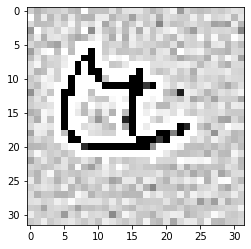

In [40]:
img_path = '/home/shoaib/Programming/Project/data/training-a'
img = os.path.join(img_path,'a00000.png')

img = cv.imread(img,cv.IMREAD_GRAYSCALE)
img = cv.resize(img,(32,32))
img_guass = cv.GaussianBlur(img,(9,9),10)
img_w = cv.addWeighted(img,1.5,img_guass,-0.5,0,img)
kernel= np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
img = cv.filter2D(img_w,-1,kernel)
img = img.reshape(32,32,1).astype('float32')
img /= 255

prediction = model.predict(img.reshape(1,32,32,1))
label =  np.argmax(prediction)

plt.imshow(img.reshape(32,32),cmap=plt.get_cmap('gray'))

In [41]:
label

5